Names:

*   Tomer Siboni,       316532282
*   Nadav Orenshtein,   312349509
*   Lior Avadyayev,     206087611

Project Title:

CNN - X-Ray Pathology Diagnoser






## Introduction

In the past few decades, X-Ray images is widely used in order to diagnose medical issues, as fractures and pathologies. The use of this technology expands, and simply require a both proffesional and experienced examine of the images for each patient. While the theoretical and some practical knowledge has been given to us in the current course, it makes sense to use a given dataset to train a computing model to do the job, saving time and may be more efficient than the average radiologist. 

The model we train in this project is going to detect chest pathologies. We will use the information of the images themselves with a multilayered CNN, and as well some more variables referring to the patient is being included in the train and may potentially be important to make decisions about pathologies. For example, some pathologies may be more common with older people, and as well women breast may affect in certain ways on the model analysis of the image.


#Task

We will design a model that diganose wether is positive to Cardiomegaly or negative base on the x-ray images and addiotional parameters. 

# Data

The data source for this project is located at kaggle website, and including close to 45,000 X-Ray images.
Our dataset consisted of images of groups of 14 different diseases and one “no findings”, each image including the patient’s index, age and gender.
While looking at the data, we noticed that some of the patients have more than one diagnose, which means that it will be difficult to check all the diseases in one NN and receive a reliable output for each, so at first we decided to check only one disease named **“cardiomegaly”** (enlarged heart), and get a true/false answer for it, it will be an easier task and we can get information that will help us to deal with the rest of the diseases.


## Data reaching process: 

1: install opendatasets and pandas libraies.

2: Download a tokken from kaggle website to colabs hard disk.

3: copy the link of the dataset and download it to colab:
"https://www.kaggle.com/datasets/nih-chest-xrays/data".



In [2]:
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import torch
from torch import nn
import torch.optim as optim 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
from skimage.transform import resize
import cv2
import torchvision

In [5]:
seed = 72
torch.manual_seed(seed)         
torch.cuda.manual_seed(seed)    

Here we download the data:

In [6]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/nih-chest-xrays/data")


100%|██████████| 42.0G/42.0G [04:58<00:00, 151MB/s]


#☕ **Loading the dataset & preprocessing the data**

Pre-processing the data is an important step in the process of building an AI that can detect pathologies in X-ray images. Proper pre-processing can help improve the performance of the model by ensuring that the data is in a consistent and suitable format for the machine learning algorithm.

Let's get the X-ray scans and the lables from the NIH dataset, analyze it and preprocess it.

In [7]:
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index              Finding Labels  Follow-up #  Patient ID  \
86451  00021307_021.png                  No Finding           21       21307   
6505   00001745_000.png  Consolidation|Infiltration            0        1745   
20009  00005348_020.png                 Atelectasis           20        5348   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
86451           43              F            PA                 2992     2991   
6505            53              M            AP                 3056     2544   
20009           48              M            PA                 2992     2991   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
86451                        0.143  0.143          NaN   
6505                         0.139  0.139          NaN   
20009                        0.143  0.143          NaN   

                                          path  
86451  data/images_010/images/00021307_021.png  
6505   data/images_002/images/00001745_000.png  
20009  data/images_003/images/00005348_020.png

##  standardizing the Patient Age
 
Examining the data brought us to the decision of standardizing the age of the patiences. Adjusting the mean to 0, and the standard deviation to 1 is a common way to make the model optimization unaffected of the scale of the data, while improving its efficiency. It is more suitable for data that is already distributed similarly to a gaussian distribution. In the case of age it is not obvious that it would be a gaussian distribution, considering that heart diseases were thought to be common for elders. Making a histogram for the age distribution made it clear that the distribution is similar to a gaussian distribution, as shown in the figure below

16.839847435450604


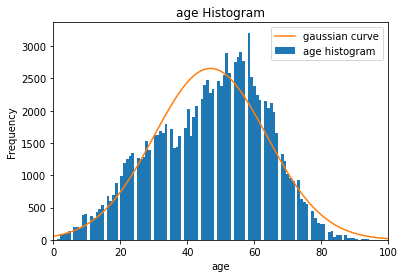

In [8]:
mu = np.mean(all_xray_df['Patient Age'])
sigma = np.std(all_xray_df['Patient Age'])
print(sigma)


plt.hist(all_xray_df['Patient Age'], bins=500)

plt.gca().set(title='age Histogram', ylabel='Frequency',xlabel = 'age');
plt.xlim([0, 100])

x_data = np.arange(0, 100, 0.001)

## y-axis as the gaussian
y_data = stats.norm.pdf(x_data, mu, sigma)*len(all_xray_df['Patient Age'])


plt.plot(x_data,y_data)
plt.legend(["gaussian curve","age histogram"])

The histogram is seem to be close enough to the gaussian curve.
 
Therefore, we would like to standardize the age such that  $\mu = 0$ , $\sigma = 1$

In [9]:
print(f'𝜇 = {mu},\t 𝜎 = {sigma}')

all_xray_df['Patient Age'] = (all_xray_df['Patient Age'])/ sigma - mu/sigma


𝜇 = 46.90146271851587,	 𝜎 = 16.839847435450604


now compute and display the new $\mu $ and $\sigma $


In [10]:
mu = np.mean(all_xray_df['Patient Age'])
sigma = np.std(all_xray_df['Patient Age'])

print(f'𝜇 = {mu},\t 𝜎 = {sigma}')

𝜇 = 2.911374712880753e-16,	 𝜎 = 1.0


let's view the difference in our dataset:





In [11]:
all_xray_df.sample(3)


Image Index   Finding Labels  Follow-up #  Patient ID  \
62862  00015546_001.png       No Finding            1       15546   
67122  00016587_024.png     Pneumothorax           24       16587   
36020  00009507_003.png  Effusion|Hernia            3        9507   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
62862    -1.359957              F            PA                 3056     2544   
67122     0.065234              F            PA                 2330     2991   
36020     0.718447              M            PA                 2890     2576   

       OriginalImagePixelSpacing[x     y]  Unnamed: 11  \
62862                        0.139  0.139          NaN   
67122                        0.143  0.143          NaN   
36020                        0.143  0.143          NaN   

                                          path  
62862  data/images_007/images/00015546_001.png  
67122  data/images_008/images/00016587_024.png  
36020  data/images_005/images/00009507_003.png

## Adjusting the output
Here we take the labels and make them into a more clear format. what's most important for us right now is to devide our label values into 2: cardiomegali diagnosed or "No finding".

In [12]:
all_xray_df['Finding Labels'] = [x.split("|") for x in all_xray_df['Finding Labels']]


In [13]:
all_xray_df['Cardiomegaly'] = [('Cardiomegaly' in x)*1 for x in all_xray_df['Finding Labels']]
all_xray_df['No Finding'] = [('No Finding' in x)*1 for x in all_xray_df['Finding Labels']]

print(f"number of patients diagnosed with cardiomegaly: {np.sum(all_xray_df['Cardiomegaly'])}")
print(f"number of patients diagnosed with No Finding: {np.sum(all_xray_df['No Finding'])}")

number of patients diagnosed with cardiomegaly: 2776
number of patients diagnosed with No Finding: 60361


1
1
1
0


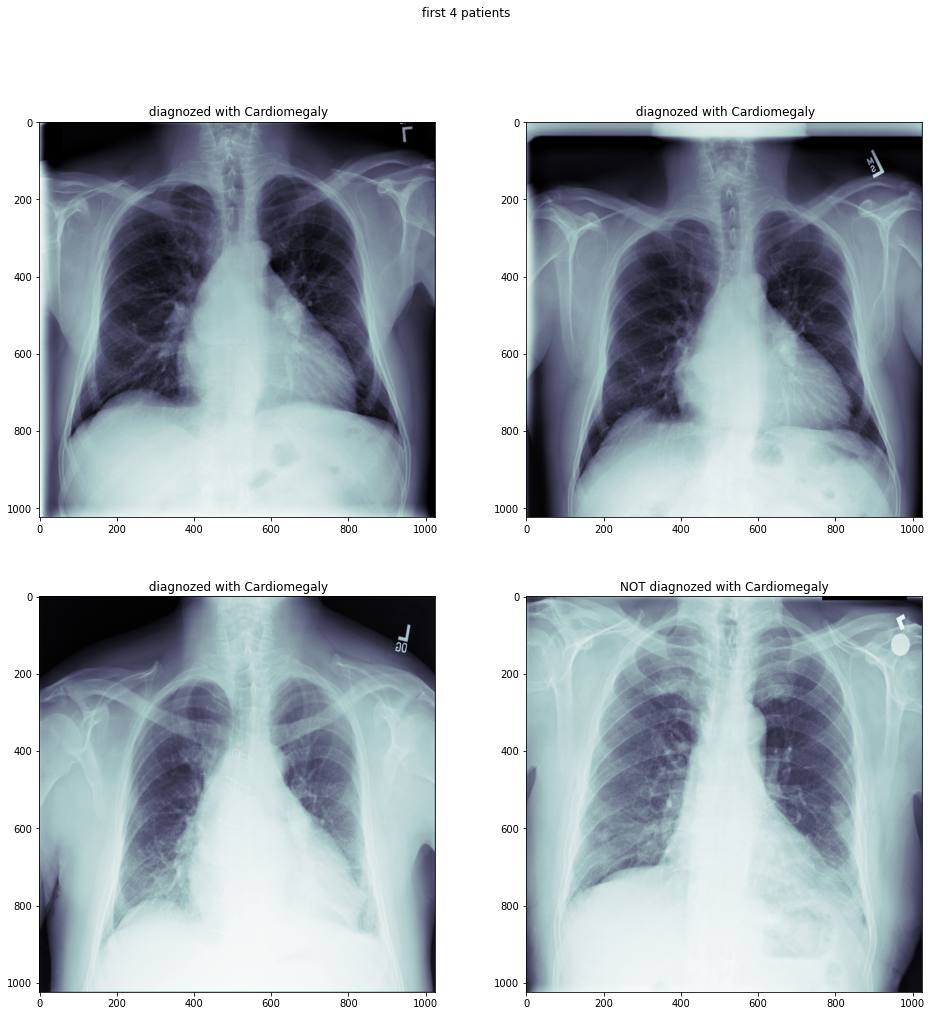

In [14]:
with_cardio = [plt.imread(all_xray_df['path'][i]) for i in range(4)]
# plt.imshow(with_cardio,cmap = 'bone')


fig, m_axs = plt.subplots(2, 2,figsize = (16, 16))
fig.suptitle('first 4 patients')

for i, ax in enumerate(m_axs.flatten()):
    
    print(all_xray_df['Cardiomegaly'][i])
    ax.imshow(with_cardio[i],cmap = 'bone')
    ax.set_title(f"{'NOT'*(not all_xray_df['Cardiomegaly'][i])} diagnozed with Cardiomegaly")



# Manipulating the data:

In [15]:
s = set()
for p in all_xray_df['Finding Labels']:
  for x in p:
    #print(x)
    s.add(x)

print(s)

{'Effusion', 'No Finding', 'Cardiomegaly', 'Mass', 'Atelectasis', 'Fibrosis', 'Hernia', 'Infiltration', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Nodule', 'Emphysema', 'Edema'}


In [16]:
corr_df = pd.DataFrame()

corr_df['Infiltration'] = [('Infiltration' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Cardiomegaly'] = [('Cardiomegaly' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Nodule'      ] = [('Nodule' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Pneumonia'   ] = [('Pneumonia' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Consolidation'] = [('Consolidation' in x)*1 for x in all_xray_df['Finding Labels']]
#corr_df['No Finding'  ] = [('No Finding' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Hernia'      ] = [('Hernia' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Pleural_Thickening'] = [('Pleural_Thickening' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Fibrosis'    ] = [('Fibrosis' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Atelectasis' ] = [('Atelectasis' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Pneumothorax'] = [('Pneumothorax' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Emphysema'   ] = [('Emphysema' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Edema'       ] = [('Edema' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Mass'        ] = [('Mass' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Effusion'    ] = [('Effusion' in x)*1 for x in all_xray_df['Finding Labels']]




<ipython-input-17-b2476bf03414>:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  df = df.dropna('columns') # drop columns with NaN


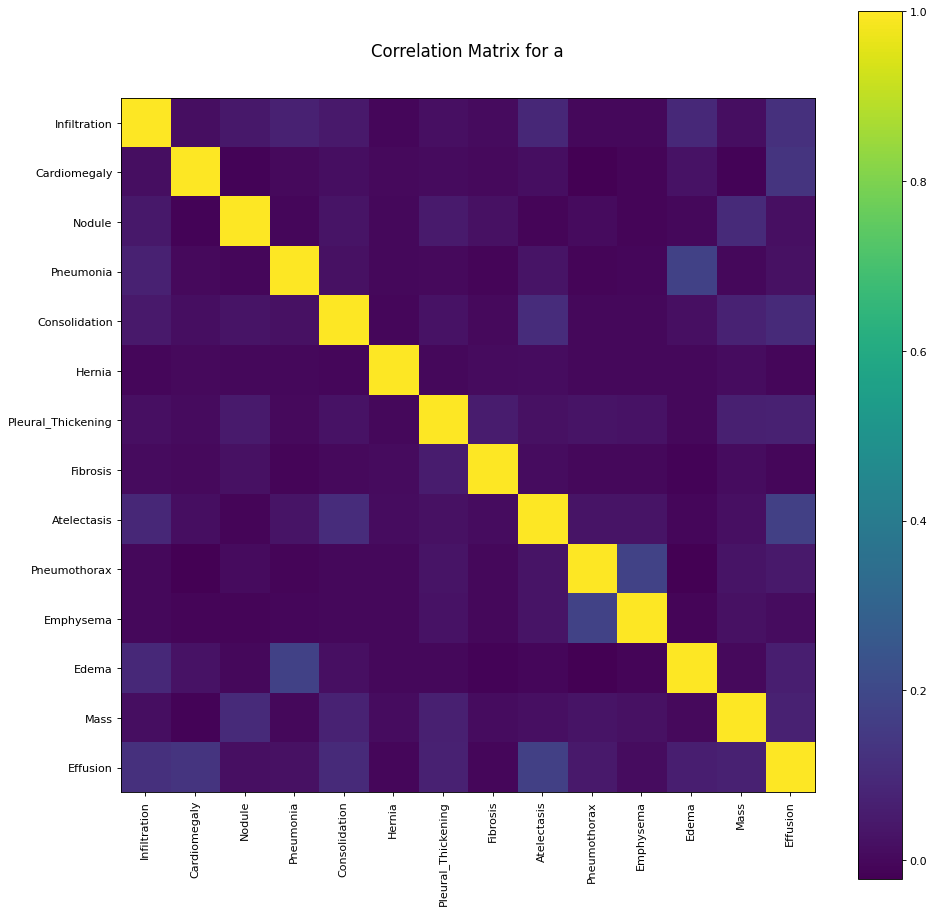

In [17]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "a"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


df = pd.DataFrame()
plotCorrelationMatrix(corr_df,14)

For checking the data we will try to resize it to different shapes to see if the quality images with different shapes.
here is a resize of the image from 1024X1024 to 224X224:

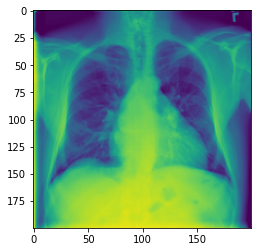

In [18]:
img = plt.imread(all_xray_df['path'][0])
img=resize(img,(224,224))
plt.imshow(img)

<ipython-input-23-6ce3c7601229>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


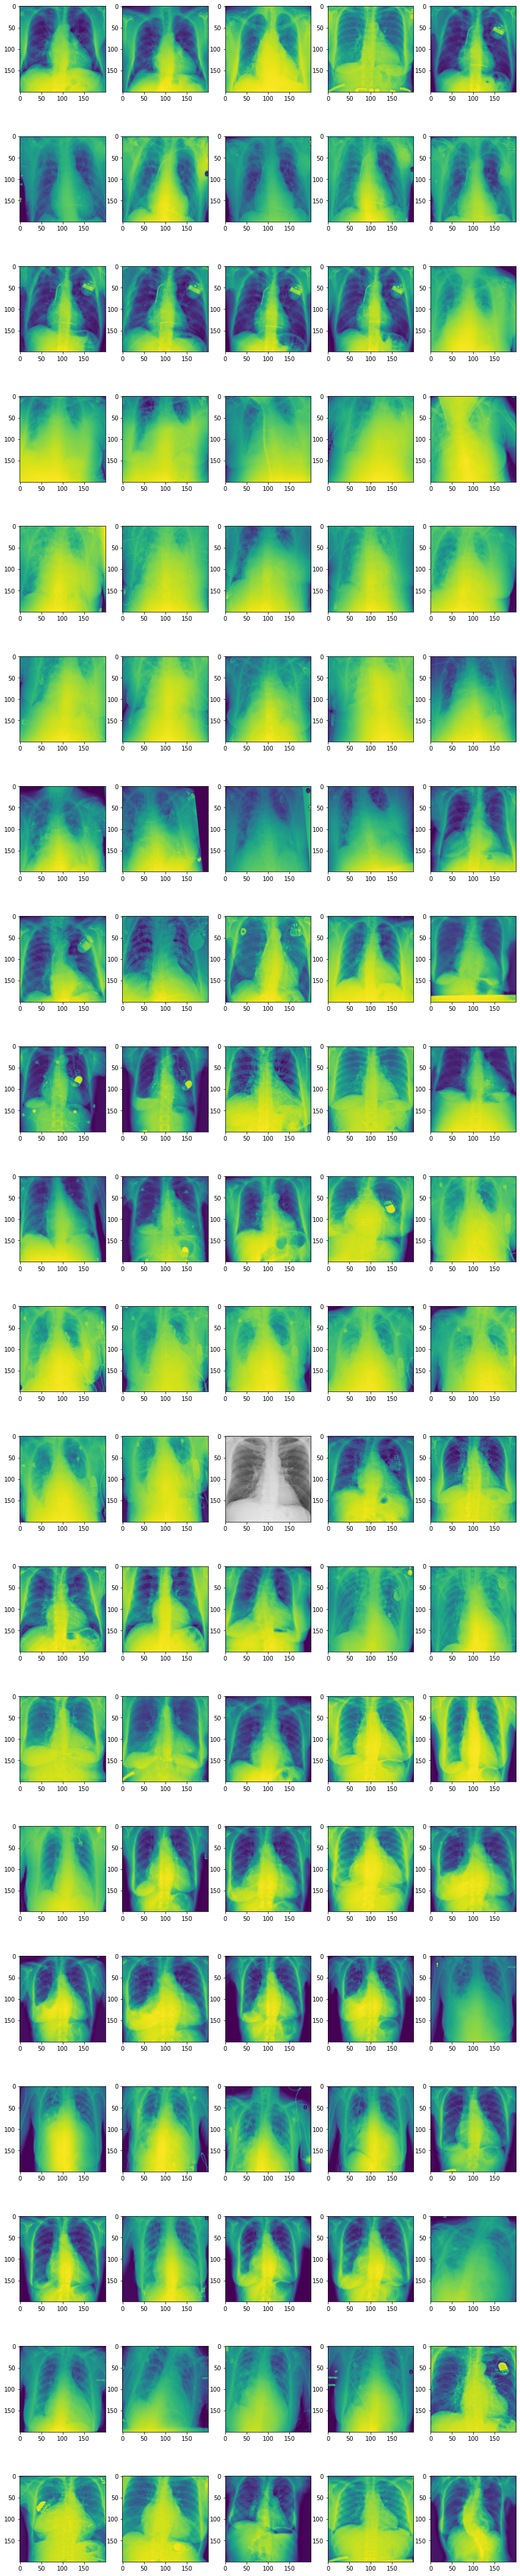

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
m, n =20, 5 
fig, axs = plt.subplots(m, n, figsize= (n*3,m*4))
for i in range(100):
  plt.figure()
  axs[i//n,i%n].imshow(resize(plt.imread(pos_train['path'][i])[144:960,80:960],(200,200)))

  

We will vectorize the Gender and the image position (front or back).

In [19]:
all_xray_df['Gender'] =  [0 if g =='M' else 1 for g in all_xray_df['Patient Gender']]
all_xray_df['position'] =  [0 if g =='AP' else 1 for g in all_xray_df['View Position']]
all_xray_df.sample(3)

Image Index                          Finding Labels  Follow-up #  \
84234  00020703_009.png  [Effusion, Infiltration, Mass, Nodule]            9   
54570  00013670_077.png                         [Consolidation]           77   
87362  00021572_019.png                           [Atelectasis]           19   

       Patient ID  Patient Age Patient Gender View Position  \
84234       20703     0.837213              M            AP   
54570       13670     0.540298              M            AP   
87362       21572    -1.241191              F            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
84234                 3056     2544                        0.139  0.139   
54570                 2500     2048                        0.168  0.168   
87362                 2992     2991                        0.143  0.143   

       Unnamed: 11                                     path  Cardiomegaly  \
84234          NaN  data/images_009/images/00020703_009.png             0   
54570          NaN  data/images_006/images/00013670_077.png             0   
87362          NaN  data/images_010/images/00021572_019.png             0   

       No Finding  Gender  position  
84234           0       0         0  
54570           0       0         0  
87362           0       1         1

In [74]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics


actual = np.random.binomial(1, 0.8, size = 1000)
predicted = np.random.binomial(1, 0.9, size = 1000)  

def confusion_matrix(z_test, t_test):
    
    confusion_matrix = metrics.confusion_matrix(z_test, t_test)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()




This function used for saving lists to disk:

In [20]:
import pickle

def save_lists(lists,path):
  for i in range(len(lists)):
    with open(path+f'{path}{i}', "wb") as f:
        pickle.dump(lists[i], f)

## Building the balanced Cardiomegali dataset

As known, having a balanced dataset is important to train any model, in order to avoid a biased model.

Assuming there are more negative cases for every disease, we take all positive cases and a close amount for the negative cases.


*   Positive - "Cardiomegaly"

*   Negative - "No findings"


In [21]:
mask = all_xray_df['Cardiomegaly'] == 1
positive = all_xray_df.loc[mask]
positive = positive.reset_index(drop=True)

neg_mask = all_xray_df['No Finding'] == 1
negative = all_xray_df.loc[neg_mask]
negative = negative.sample(frac=1).reset_index(drop=True)


#chosen_idx = np.random.choice(len(negative), replace = False, size = int(n*1.2))




## Normalizing the images
  Normalizing the images can help the machine learning algorithm learn more effectively. One common way to normalize images is to scale the pixel values to have zero mean and unit range. Normalizing the data can help reduce the range of the input values. It can make the optimization process faster and more stable. Moreover, this process can reduce the model’s sensitivity to the scale of the input.
Why is this better than another type of preprocessing the data?
A different type of preprocessing the data is standardization, and is usually used when the input data is known to distribute close to a gaussian distribution. 

Our conclusions:
In the case of this project using X-Ray images, we assume a skewed distribution. The images are grayscale and seem to contain relatively a large amount of pixels that are far from the average - white or very light gray indicates the presence of bones or more dense tissues, while dark gray or black represents the absence of it.
Therefore we chose to use the normalization method for preprocessing the data, yet we might consider trying the other method, as experiments on the actual full dataset can be unexpected.
The NIH dataset provides us with pre-normalized images, therefore we use the provided images as is.

## Split the Data to Train, Valid and Test



*   positive - "cardiomegaly"

*   negative - "No findings"

In order to train the model we are going to use a separated dataset for training, validation and testing the model.
80% of the data is meant to be used as training data for the model, to find patterns and get better in its inference.
10% is meant to be used as a validation for the model, in order to check the quality of the model over different data as it is being trained.

While training the model the separation can verify overfitting when occurs, and allow making conclusions of the algorithm's properties and behavior.

Another 10% of the data is to be used for final testing of the trained model over a completely new data that hasn't been seen while training the model.


In [22]:
TRAINSIZE = 0.86
VALSIZE = 0.93


p =len(positive)
n = len(negative)
N = n+p


data = pd.concat([positive,negative]).sample(frac=1).reset_index(drop=True)


pos_train, pos_test, pos_val = positive.iloc[:int(TRAINSIZE*p)], positive.iloc[int(TRAINSIZE*p):int(VALSIZE*p)],positive.iloc[int(VALSIZE*p):]
neg_train, neg_test, neg_val = negative.iloc[:int(TRAINSIZE*n)], negative.iloc[int(TRAINSIZE*n):int(VALSIZE*n)],negative.iloc[int(VALSIZE*n):n]
data_train, data_test, data_val = data.iloc[:int(TRAINSIZE*N)], data.iloc[int(TRAINSIZE*N):int(VALSIZE*N)],data.iloc[int(VALSIZE*N):]

data_train = data_train.reset_index(drop=True)
pos_train = pos_train.reset_index(drop=True)
neg_train = neg_train.reset_index(drop=True)

data_test = data_test.reset_index(drop=True)
pos_test = pos_test.reset_index(drop=True)
neg_test = neg_test.reset_index(drop=True)

data_val = data_val.reset_index(drop=True)
pos_val = pos_val.reset_index(drop=True)
neg_val = neg_val.reset_index(drop=True)
pos_val


Image Index                                     Finding Labels  \
0    00028526_003.png                           [Cardiomegaly, Effusion]   
1    00028526_009.png                                     [Cardiomegaly]   
2    00028526_015.png                    [Cardiomegaly, Edema, Effusion]   
3    00028526_016.png                       [Cardiomegaly, Infiltration]   
4    00028534_001.png                                     [Cardiomegaly]   
..                ...                                                ...   
190  00030764_000.png                                     [Cardiomegaly]   
191  00030786_002.png  [Cardiomegaly, Effusion, Emphysema, Pneumothorax]   
192  00030786_003.png  [Cardiomegaly, Effusion, Emphysema, Pneumothorax]   
193  00030786_004.png  [Cardiomegaly, Effusion, Emphysema, Pneumothorax]   
194  00030786_005.png                [Cardiomegaly, Effusion, Emphysema]   

     Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
0              3       28526    -0.766127              M            AP   
1              9       28526    -0.766127              M            AP   
2             15       28526    -0.766127              M            AP   
3             16       28526    -0.766127              M            AP   
4              1       28534     0.955979              F            PA   
..           ...         ...          ...            ...           ...   
190            0       30764    -0.647361              M            PA   
191            2       30786     0.837213              F            AP   
192            3       30786     0.837213              F            AP   
193            4       30786     0.837213              F            AP   
194            5       30786     0.837213              F            AP   

     OriginalImage[Width  Height]  OriginalImagePixelSpacing[x        y]  \
0                   3056     2544                     0.139000  0.139000   
1                   3056     2544                     0.139000  0.139000   
2                   3056     2544                     0.139000  0.139000   
3                   2544     3056                     0.139000  0.139000   
4                   2021     2021                     0.194311  0.194311   
..                   ...      ...                          ...       ...   
190                 2021     2021                     0.194311  0.194311   
191                 3056     2544                     0.139000  0.139000   
192                 3056     2544                     0.139000  0.139000   
193                 3056     2544                     0.139000  0.139000   
194                 3056     2544                     0.139000  0.139000   

     Unnamed: 11                                     path  Cardiomegaly  \
0            NaN  data/images_012/images/00028526_003.png             1   
1            NaN  data/images_012/images/00028526_009.png             1   
2            NaN  data/images_012/images/00028526_015.png             1   
3            NaN  data/images_012/images/00028526_016.png             1   
4            NaN  data/images_012/images/00028534_001.png             1   
..           ...                                      ...           ...   
190          NaN  data/images_012/images/00030764_000.png             1   
191          NaN  data/images_012/images/00030786_002.png             1   
192          NaN  data/images_012/images/00030786_003.png             1   
193          NaN  data/images_012/images/00030786_004.png             1   
194          NaN  data/images_012/images/00030786_005.png             1   

     No Finding  Gender  position  
0             0       0         0  
1             0       0         0  
2             0       0         0  
3             0       0         0  
4             0       1         1  
..          ...     ...       ...  
190           0       0         1  
191           0       1         0  
192           0       1         0  
193           0       1         0 

## Transforming the Dataset to Tensors

Our data is stored in collabs hard disc what cause high runtime, we will write a function that will store the train, val, test images in tensors and then use it for the data. Using the images as tensors is necessary for model training.

In [23]:
def collect_tensor(data,H,W):
  n=len(data)
  data_array = torch.zeros((n,H,W))
  variables = torch.zeros((n,3))


  for j in range(n):
    if plt.imread(data['path'][j]).shape==(1024,1024):
      #data_array[j] = torch.tensor(plt.imread(data['path'][j]))
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[144:960,80:960],(H,W)))   
    else:
      #data_array[j] = torch.tensor(plt.imread(data['path'][j])[:,:,0])
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[144:960,80:960,0],(H,W)))
    
    
    variables[j,0] = data['Patient Age'][j]
    variables[j,1] = data['Gender'][j]
    variables[j,2] = data['position'][j]

  return data_array, variables
     




For testing the data we will try to look for different crops for the image, and different resizes to decide what transformation  good for the data.

In [138]:
H=224
W=242

pos_train_arr , vars_pos_train_arr = collect_tensor(pos_train,H,W)

pos_test_arr , vars_pos_test_arr = collect_tensor(pos_test,H,W)

pos_val_arr  , vars_pos_val_arr = collect_tensor(pos_val,H,W)

neg_train_arr  , vars_neg_train_arr = collect_tensor(neg_train[:2500],H,W)

neg_test_arr ,vars_neg_test_arr = collect_tensor(neg_test[:300],H,W)

neg_val_arr  ,vars_neg_val_arr = collect_tensor(neg_val[:300],H,W)


# Limitations:
In this project we were using a published dataset that contaings close to 45,000 X-Ray images along with some more information about each patient examined, and as well its history.

The size of the dataset seemed to be large enough, though much of the data is not to be used. As found in the previous chapter, for the pathology "Cardiomegaly" there are only few thousands of images, so in order to use a perfectly balanced data it is needed to rely on a relatively small amount of images. As shown, we made it modifyable - potentially it is possible to reach more data, therefore it would be best to perfectly balance the positive and negative data.

In addition, anothe limitation of the dataset that is later found was that some of the images were not in a very good quality.

Therefore, while considering this dataset as a practical source that is used to asses a potentially better training architecture.



# 🕸 **Network architecture**

Now we will build the architecture of the model.

important to mention that we used some image shapes: 1024X1024, 880X816, 200X200.

**BLOCK 1:**



*   Convolutional layer (nn.Conv2D(in_channels, num_hidden,kernel_size=(3,3), stride=(2,2)))

*   Batch Normalization(num_hidden)




*   MaxPool2d(kernel_size=2, stride=2))

*   Activation Function: nn.ReLU()







**BLOCK 2:**






*   Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))

*   Activation Function: nn.ReLU()

*   Batch Normalization(num_hidden * 2)
*   MaxPool2d(kernel_size=2, stride=2))



**BLOCK 3:**


*   Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))

*   Activation Function: nn.ReLU()

*   Batch Normalization(num_hidden * 4)


 
**BLOCK 4:**


*   Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))

*   Activation Function: nn.ReLU()



*   Batch Normalization(num_hidden * 8)











**BLOCK 5:**


*   FC layer(3 * 3 * 8 * num_hiddens,100)

*   Activation Function: nn.Sigmoid()

*   FC layer(100,20)

*   Activation Function: nn.Sigmoid())




**BLOCK 6:**

In this chapter we add the arguments: [Age,Gender,angle]
                           

*   FC layer(20 + num_vars, 2)
*   nn.Sigmoid()





In [89]:
class CNN1(nn.Module):
    def __init__(self, num_hiddens,num_vars=0):

        
        super(CNN1, self).__init__()

        H = 1024
        W = 1024
        in_channels = 1
        self.num_hiddens = num_hiddens
        self.num_vars=num_vars
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.ReLU())
        
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, num_hiddens*2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens*2),
                                    nn.ReLU())

        self.block3 = nn.Sequential(nn.Conv2d(num_hiddens*2, num_hiddens*4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens*4),
                                    nn.ReLU())
        
        self.block4 = nn.Sequential(nn.Conv2d(num_hiddens*4, num_hiddens*8, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens*8),
                                    nn.ReLU())


        self.fc_block1 = nn.Sequential(nn.Linear((W//16)*(H//16)*8*num_hiddens,100), #flatten the CNN output -> Block 5
                                       nn.Sigmoid(),
                                       nn.Linear(100,20),
                                       nn.Sigmoid())
        
        self.fc_block2 =  nn.Sequential(nn.Linear(20 + num_vars, 10), #flatten the CNN output -> Block 6
                                       nn.Sigmoid(),
                                       nn.Linear(10,2),
                                       nn.Sigmoid())
         

    def forward(self,x,vars=0):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.contiguous().view(-1,(W//16)*(H//16)*8*self.num_hiddens) # reshape for tensor
        x = self.fc_block1(x)
        if self.num_vars>0:
          x= torch.cat((x,vars),1)
        x = self.fc_block2(x)

        return x




# Benchmarks

We will import real-world state of the art models that are well known for their good detection accuracy in many test cases and some, specifically on the NIH dataset (AlexNet and Resnet18).

For this project, reaching an accuracy of more than 70% is determined to be a good result that would be potentially rise with bigger and higher-quality dataset as described above.

## **Evaluation function**

We will test the accuracy of the positive and negative separately.



In [36]:
path_saving  = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio'

In [53]:
def get_accuracy(model, 
                 pos,
                 neg,
                 batch_size=50, 
                 vars=False,
                 pos_val_var=vars_pos_val_arr,
                 neg_val_var=vars_neg_val_arr):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """
    len_pos= len(pos)
    len_neg=len(neg)
    model.eval()
    acc_pos=0
    acc_neg=0
    H=224
    W=242
    
      
    pos_correct = 0
    for i in range(0, len_pos, batch_size):
        if (i+batch_size)>len_pos:
          break
        acc_pos += batch_size
        xt , var_xt = pos[i:i+batch_size],pos_val_var[i:i+batch_size]

        ##### choose how many channels #####        
        xt=xt.reshape(batch_size,H,W,1)
        xt=xt.reshape(batch_size,1,H,W)
        xt = torch.cat((xt,xt,xt),3)  #GRAYSCALE to RGB for training the resnet18,VGG16 models
        xt=xt.reshape(batch_size,3,H,W)

        if torch.cuda.is_available():
            xt , var_xt = xt.cuda() , var_xt.cuda()
        if vars:
          zs = model(xt,var_xt) # forwarding the model with the variables- Age, Gender, position (front or back)            
        if not vars:
          zs = model(xt)  # forwarding the model without variables
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len_pos, batch_size):
        if (i+batch_size)>len_pos:
            break
        acc_neg += batch_size
        xt , var_xt = neg[i:i+batch_size],neg_val_var[i:i+batch_size]

        ##### choose how many channels ######
        xt=xt.reshape(batch_size,H,W,1)
        xt=xt.reshape(batch_size,1,H,W)
        xt = torch.cat((xt,xt,xt),3)  #GRAYSCALE to RGB for training the resnet18,VGG16 models
        xt=xt.reshape(batch_size,3,H,W)


        if torch.cuda.is_available():
            xt , var_xt = xt.cuda() , var_xt.cuda()
        if vars:
          zs = model(xt,var_xt) # forwarding the model with the variables- Age, Gender, position (front or back)            
        else:
          zs = model(xt)  # forwarding the model without variables
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct/acc_pos, neg_correct/acc_neg

## **Training function**

While training the different models we had to modify the training function multiple times.

* Loss function - Cross Entropy

* optimizer - Stochasic gradient descent


In [34]:
def nn_train1(model,
              p_train = pos_train_arr,
              n_train = neg_train_arr,
              p_val = pos_val_arr,
              n_val = neg_val_arr,
              batch_size=10,
              learning_rate=0.001,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=None,
              vars = False,
              pos_tr_var=vars_pos_train_arr,
              neg_tr_var=vars_neg_train_arr
              ):
#main training loop; choice of loss function; choice of optimizer
  #print("hi")

 
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.cuda()
  
  
  optimizer = optim.SGD(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay,
                           momentum=0.9)
  
  iters, losses = [], []
  iters_sub, train_accs_pos , train_accs_neg, val_accs_pos, val_accs_neg  = [], [] ,[],[],[]
  
  len_data= min(len(p_train),len(n_train))
  acc_len_pos=0
  acc_len_neg=0
  H=224
  W=242
  n = 0 # the number of iterations
  while n < max_iters:
      for i in range(0, len_data, batch_size):
            if (i + batch_size) > len_data:
                break
            
            model.train()
            
            #in each iteration, take batch_size / 2 positive samples and batch_size / 2 negative samples as our input for this batch
            #pos_st,neg_st = np.ones(batch_size / 2), np.zeros(batch_size / 2)

            xt=torch.zeros((2*batch_size,H,W))  #define empty tensor for batch
            pos_st,neg_st = np.ones((batch_size)), np.zeros((batch_size))  #define batch//2 positive and batch//2 negative
            st = np.concatenate((pos_st,neg_st),axis=0)
            st = np.random.permutation(st)  #permutate the positive and negative outputs
            st_or = torch.zeros((2*batch_size,2)) #define output tensor -  negative : [1,0], positive : [0,1] 
            xt_vars = torch.zeros((2*batch_size,3)) # define tensor for variables : [Age, gender , Angle]
            
            #building the batch input tensors
            
            pos_idx=i
            neg_idx=i
            j=-1
                     
            while( pos_idx+neg_idx<2*i+2*batch_size):  
              j+=1 
              if st[j]:
                xt[j]=p_train[pos_idx]
                st_or[j,1]=1
                if vars:
                  xt_vars[j][0]=pos_tr_var[pos_idx,0]
                  xt_vars[j][1]=pos_tr_var[pos_idx,1]
                  xt_vars[j][2]=pos_tr_var[pos_idx,2]
                pos_idx+=1

              else:
                xt[j]=n_train[neg_idx]
                st_or[j,0]=1
                if vars:
                  xt_vars[j][0]=neg_tr_var[neg_idx,0]
                  xt_vars[j][1]=neg_tr_var[neg_idx,1]
                  xt_vars[j][2]=neg_tr_var[neg_idx,2]
                neg_idx+=1
              
          
            
            #conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions  N×C×H×W  (known as NCHW tensor)
            #.. where  N  is the number of images batch size,  C  is the number of channels,  H  is the height of the image, and  W  is the width of the image.
            
          
            xt=xt.reshape(2*batch_size,H,W,1)
            xt=xt.reshape(2*batch_size,1,H,W)

            #xt = torch.cat((xt,xt,xt),3)  #GRAYSCALE to RGB for training the resnet18,VGG16 models
            #xt=xt.reshape(2*batch_size,3,H,W)
    
            if torch.cuda.is_available():
                xt , xt_vars , st = xt.cuda() , xt_vars.cuda() , st_or.cuda()
            
            if vars:
              zs = model(xt,xt_vars) # forwarding the model with the variables- Age, Gender, position (front or back)
            
            else:
              zs = model(xt)  # forwarding the model without variables

            #print('zs=', zs.shape, zs)  
            optimizer.zero_grad()
            loss = criterion(zs, st)
            loss.backward()
            losses.append(float(loss)/batch_size) 
            optimizer.step()
            

            #after every epoch, report the accuracies for the training set and validation set
            if n % 100==0:
                iters_sub.append(n)
                train_cost = float(loss.detach().cpu().numpy())
                train_acc_pos,train_acc_neg  = get_accuracy(model, p_train[:300],n_train,batch_size,vars,pos_tr_var,neg_tr_var)
                train_accs_pos.append(train_acc_pos)
                train_accs_neg.append(train_acc_neg)
                val_acc_pos , val_acc_neg = get_accuracy(model, p_val,n_val,batch_size,vars)
                val_accs_pos.append(val_acc_pos)
                val_accs_neg.append(val_acc_neg)
                print("Iter %d. [Val pos Acc %.0f%%] [Val neg Acc %.0f%%] [Train pos Acc %.0f%%,Train neg Acc %.0f%%, Loss %f]" % (n, val_acc_pos * 100,val_acc_neg * 100, train_acc_pos * 100, train_acc_neg * 100, train_cost))

                if (checkpoint_path is not None):  #save model
                    n_path = checkpoint_path + f"{n}"
                    torch.save(model.state_dict(), n_path.format(n))
            # increment the iteration number
            n += 1

            if n > max_iters:
              return model,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg
        
            
            


          #track the training curve information and plot the training curve
        
              
  return model,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg

# 💪 **Training the Model: Trial & Error**

# Training model 1:

## **Sanity check**:

we will try to memorize the data for 10 positive and 10 negative samples

In [67]:
if torch.cuda.is_available():
  CNN_20 = CNN1(3).cuda()
else:
  CNN_20 = CNN1(3)



In [68]:
CNN_20,CNN_20_losses, CNN_20__train_accs_pos, CNN_20__train_accs_neg, CNN_20__val_accs_pos, CNN_20__val_accs_neg  = nn_train1(CNN_20,p_train=pos_train_arr[:10],n_train=neg_train_arr[:10],p_val=pos_val_arr,n_val=neg_val_arr,batch_size=5,learning_rate=0.01,
              weight_decay=0,
              max_iters=700,
              checkpoint_path=path_saving+'_CNN20_')

Iter 0. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.694184]
Iter 100. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.690895]
Iter 200. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.687325]
Iter 300. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.679830]
Iter 400. [Val pos Acc 90%] [Val neg Acc 14%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.660529]
Iter 500. [Val pos Acc 68%] [Val neg Acc 42%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.608640]
Iter 600. [Val pos Acc 52%] [Val neg Acc 53%] [Train pos Acc 100%,Train neg Acc 100%, Loss 0.509012]


we see that our model memorize the training data after 400 iterations.


## **First training**

Now we will train the model for the first time. For curiosity, at first we train the images with 1024X1024 size to see how good the results we get.

**hyperparameters:**

batch size = 50 positive + 50 negative

learning rate = 0.001

In [74]:
if torch.cuda.is_available():
  CNN_cardio = CNN1(3).cuda()
else:
  CNN_cardio = CNN1(3)
  

In [75]:
CNN_cardio,CNN_cardio_losses, CNN_cardio__train_accs_pos, CNN_cardio__train_accs_neg, CNN_cardio__val_accs_pos, CNN_cardio__val_accs_neg  = nn_train1(CNN_cardio,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=50,learning_rate=0.001,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=path_saving+'_CNN-Cardio_')

Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.697015]
Iter 100. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.696205]
Iter 200. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.695483]
Iter 300. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.694997]
Iter 400. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.694474]
Iter 500. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.694021]
Iter 600. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693766]
Iter 700. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693532]
Iter 800. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693390]
Iter 900. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693540]
Iter 1000. [

we see that there is no progress, we will try to increase the leraning rate and keep training

In [76]:
CNN_cardio,CNN_cardio_losses, CNN_cardio__train_accs_pos, CNN_cardio__train_accs_neg, CNN_cardio__val_accs_pos, CNN_cardio__val_accs_neg  = nn_train1(CNN_cardio,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=50,learning_rate=0.01,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=path_saving+'_CNN-Cardio_')

Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693392]
Iter 100. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.692956]
Iter 200. [Val pos Acc 27%] [Val neg Acc 79%] [Train pos Acc 46%,Train neg Acc 73%, Loss 0.692418]
Iter 300. [Val pos Acc 49%] [Val neg Acc 49%] [Train pos Acc 74%,Train neg Acc 47%, Loss 0.693330]
Iter 400. [Val pos Acc 53%] [Val neg Acc 48%] [Train pos Acc 79%,Train neg Acc 43%, Loss 0.691263]
Iter 500. [Val pos Acc 55%] [Val neg Acc 48%] [Train pos Acc 79%,Train neg Acc 44%, Loss 0.689640]
Iter 600. [Val pos Acc 57%] [Val neg Acc 47%] [Train pos Acc 78%,Train neg Acc 46%, Loss 0.689047]
Iter 700. [Val pos Acc 59%] [Val neg Acc 47%] [Train pos Acc 79%,Train neg Acc 47%, Loss 0.686991]
Iter 800. [Val pos Acc 58%] [Val neg Acc 51%] [Train pos Acc 78%,Train neg Acc 50%, Loss 0.685822]
Iter 900. [Val pos Acc 53%] [Val neg Acc 53%] [Train pos Acc 80%,Train neg Acc 54%, Loss 0.689476]
Iter 1000. [

we will try 1500 more iterations

In [78]:
CNN_cardio,CNN_cardio_losses, CNN_cardio__train_accs_pos, CNN_cardio__train_accs_neg, CNN_cardio__val_accs_pos, CNN_cardio__val_accs_neg  = nn_train1(CNN_cardio,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=50,learning_rate=0.01,
              weight_decay=0,
              max_iters=1500,
              checkpoint_path=path_saving+'_CNN-Cardio_')

Iter 0. [Val pos Acc 51%] [Val neg Acc 64%] [Train pos Acc 77%,Train neg Acc 67%, Loss 0.675379]
Iter 100. [Val pos Acc 56%] [Val neg Acc 64%] [Train pos Acc 78%,Train neg Acc 66%, Loss 0.670414]
Iter 200. [Val pos Acc 51%] [Val neg Acc 67%] [Train pos Acc 78%,Train neg Acc 70%, Loss 0.653134]
Iter 300. [Val pos Acc 51%] [Val neg Acc 64%] [Train pos Acc 83%,Train neg Acc 69%, Loss 0.684246]
Iter 400. [Val pos Acc 49%] [Val neg Acc 62%] [Train pos Acc 83%,Train neg Acc 71%, Loss 0.615325]
Iter 500. [Val pos Acc 41%] [Val neg Acc 72%] [Train pos Acc 79%,Train neg Acc 78%, Loss 0.570289]
Iter 600. [Val pos Acc 71%] [Val neg Acc 62%] [Train pos Acc 88%,Train neg Acc 69%, Loss 0.552889]
Iter 700. [Val pos Acc 74%] [Val neg Acc 68%] [Train pos Acc 84%,Train neg Acc 74%, Loss 0.539118]
Iter 800. [Val pos Acc 44%] [Val neg Acc 82%] [Train pos Acc 73%,Train neg Acc 85%, Loss 0.503687]
Iter 900. [Val pos Acc 55%] [Val neg Acc 67%] [Train pos Acc 90%,Train neg Acc 81%, Loss 0.516577]
Iter 1000. [

we see that in iteration 700 we got an average validation accuracy 71%, we will load the model from that iteration and lower the learning rate for getting smaller changes.

In [80]:
CNN_cardio.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_CNN-Cardio_700'))
CNN_cardio,CNN_cardio_losses, CNN_cardio__train_accs_pos, CNN_cardio__train_accs_neg, CNN_cardio__val_accs_pos, CNN_cardio__val_accs_neg  = nn_train1(CNN_cardio,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=50,learning_rate=0.0001,
              weight_decay=0,
              max_iters=800,
              checkpoint_path=path_saving+'_CNN-Cardio+_')

Iter 0. [Val pos Acc 75%] [Val neg Acc 68%] [Train pos Acc 84%,Train neg Acc 74%, Loss 0.549407]
Iter 100. [Val pos Acc 66%] [Val neg Acc 68%] [Train pos Acc 87%,Train neg Acc 78%, Loss 0.574806]
Iter 200. [Val pos Acc 61%] [Val neg Acc 69%] [Train pos Acc 86%,Train neg Acc 78%, Loss 0.530520]
Iter 300. [Val pos Acc 57%] [Val neg Acc 68%] [Train pos Acc 87%,Train neg Acc 79%, Loss 0.588613]
Iter 400. [Val pos Acc 57%] [Val neg Acc 69%] [Train pos Acc 87%,Train neg Acc 78%, Loss 0.515210]
Iter 500. [Val pos Acc 60%] [Val neg Acc 69%] [Train pos Acc 87%,Train neg Acc 78%, Loss 0.507893]
Iter 600. [Val pos Acc 59%] [Val neg Acc 69%] [Train pos Acc 86%,Train neg Acc 78%, Loss 0.514101]
Iter 700. [Val pos Acc 59%] [Val neg Acc 68%] [Train pos Acc 87%,Train neg Acc 78%, Loss 0.540233]
Iter 800. [Val pos Acc 60%] [Val neg Acc 68%] [Train pos Acc 87%,Train neg Acc 77%, Loss 0.513102]


our first model got maximum of 71.5% average accuracy which includes 68% accuracy of 'no findings' images and 75% accuracy of 'cardiomegaly' cases.



# Training with parameters:


Now we will use more information in our data, we will add 3 arguments to the training model which are - Age, Gender and Position(front or back).

In [114]:
if torch.cuda.is_available():
  CNN_cardio_arg = CNN1(3,3).cuda()
else:
  CNN_cardio_arg = CNN1(3,3)

In [115]:
CNN_cardio_arg,CNN_cardio_arg_losses, CNN_cardio_arg_train_accs_pos, CNN_cardio_arg_train_accs_neg, CNN_cardio_arg_val_accs_pos, CNN_cardio_arg_val_accs_neg  = nn_train1(CNN_cardio_arg,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.01,
              weight_decay=0,
              max_iters=1000,
              vars=True,
              checkpoint_path=path_saving+'_CNN-Cardio_arg')

Iter 0. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.693688]
Iter 100. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.692826]
Iter 200. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.692921]
Iter 300. [Val pos Acc 92%] [Val neg Acc 14%] [Train pos Acc 97%,Train neg Acc 16%, Loss 0.692919]
Iter 400. [Val pos Acc 83%] [Val neg Acc 28%] [Train pos Acc 95%,Train neg Acc 29%, Loss 0.692745]
Iter 500. [Val pos Acc 78%] [Val neg Acc 33%] [Train pos Acc 93%,Train neg Acc 34%, Loss 0.692904]
Iter 600. [Val pos Acc 75%] [Val neg Acc 41%] [Train pos Acc 91%,Train neg Acc 38%, Loss 0.691069]
Iter 700. [Val pos Acc 76%] [Val neg Acc 40%] [Train pos Acc 90%,Train neg Acc 38%, Loss 0.693716]
Iter 800. [Val pos Acc 73%] [Val neg Acc 44%] [Train pos Acc 91%,Train neg Acc 41%, Loss 0.691356]
Iter 900. [Val pos Acc 74%] [Val neg Acc 44%] [Train pos Acc 90%,Train neg Acc 43%, Loss 0.689426]
Iter 1000. [

In [116]:
CNN_cardio_arg,CNN_cardio_arg_losses, CNN_cardio_arg_train_accs_pos, CNN_cardio_arg_train_accs_neg, CNN_cardio_arg_val_accs_pos, CNN_cardio_arg_val_accs_neg  = nn_train1(CNN_cardio_arg,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.01,
              weight_decay=0,
              max_iters=1000,
              vars=True,
              checkpoint_path=path_saving+'_CNN-Cardio_arg')

Iter 0. [Val pos Acc 76%] [Val neg Acc 45%] [Train pos Acc 90%,Train neg Acc 43%, Loss 0.688842]
Iter 100. [Val pos Acc 78%] [Val neg Acc 46%] [Train pos Acc 90%,Train neg Acc 44%, Loss 0.688563]
Iter 200. [Val pos Acc 78%] [Val neg Acc 52%] [Train pos Acc 88%,Train neg Acc 47%, Loss 0.687533]
Iter 300. [Val pos Acc 78%] [Val neg Acc 53%] [Train pos Acc 87%,Train neg Acc 49%, Loss 0.686826]
Iter 400. [Val pos Acc 76%] [Val neg Acc 58%] [Train pos Acc 83%,Train neg Acc 55%, Loss 0.684135]
Iter 500. [Val pos Acc 74%] [Val neg Acc 59%] [Train pos Acc 82%,Train neg Acc 58%, Loss 0.684570]
Iter 600. [Val pos Acc 72%] [Val neg Acc 61%] [Train pos Acc 79%,Train neg Acc 63%, Loss 0.669613]
Iter 700. [Val pos Acc 71%] [Val neg Acc 63%] [Train pos Acc 80%,Train neg Acc 64%, Loss 0.679530]
Iter 800. [Val pos Acc 68%] [Val neg Acc 65%] [Train pos Acc 78%,Train neg Acc 67%, Loss 0.643542]
Iter 900. [Val pos Acc 73%] [Val neg Acc 66%] [Train pos Acc 80%,Train neg Acc 67%, Loss 0.621529]
Iter 1000. [

In [117]:
CNN_cardio_arg.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_CNN-Cardio_arg900'))

CNN_cardio_arg,CNN_cardio_arg_losses, CNN_cardio_arg_train_accs_pos, CNN_cardio_arg_train_accs_neg, CNN_cardio_arg_val_accs_pos, CNN_cardio_arg_val_accs_neg  = nn_train1(CNN_cardio_arg,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.001,
              weight_decay=0,
              max_iters=1000,
              vars=True,
              checkpoint_path=path_saving+'_CNN-Cardio_arg2')

Iter 0. [Val pos Acc 72%] [Val neg Acc 66%] [Train pos Acc 80%,Train neg Acc 67%, Loss 0.634229]
Iter 100. [Val pos Acc 68%] [Val neg Acc 69%] [Train pos Acc 80%,Train neg Acc 68%, Loss 0.639563]
Iter 200. [Val pos Acc 71%] [Val neg Acc 70%] [Train pos Acc 80%,Train neg Acc 68%, Loss 0.622040]
Iter 300. [Val pos Acc 66%] [Val neg Acc 69%] [Train pos Acc 81%,Train neg Acc 68%, Loss 0.630426]
Iter 400. [Val pos Acc 68%] [Val neg Acc 70%] [Train pos Acc 80%,Train neg Acc 68%, Loss 0.629900]
Iter 500. [Val pos Acc 66%] [Val neg Acc 70%] [Train pos Acc 81%,Train neg Acc 68%, Loss 0.636108]
Iter 600. [Val pos Acc 66%] [Val neg Acc 70%] [Train pos Acc 80%,Train neg Acc 69%, Loss 0.612070]
Iter 700. [Val pos Acc 65%] [Val neg Acc 70%] [Train pos Acc 81%,Train neg Acc 68%, Loss 0.648466]
Iter 800. [Val pos Acc 65%] [Val neg Acc 70%] [Train pos Acc 81%,Train neg Acc 70%, Loss 0.598810]
Iter 900. [Val pos Acc 66%] [Val neg Acc 71%] [Train pos Acc 81%,Train neg Acc 70%, Loss 0.596031]
Iter 1000. [

# First model summerize:
We trained the model twice, in the first training we trained the images without the additional arguments (Age,Gender,position) and in the second training we added them to one of the Fully connected layer.

1. In the first training we see an overfitting - the Training data accuracy is much higher then the validation.

2. In the second training we see that the model did not succeed to memorize the data at all and got a maximum with a low accuracy. we can guess that the reason for that is that arguments may cause the model to give them high attention (for example the patient's distribution of cardiomegaly cases reach a maximum in the 60's years old patients so the model may decide that 60 means positive)


we will modify the model in the next section.

## Model 2 training:

In this chapter we modified the layers of the model.

1. for the overfitting we added a max pooling layers to make model more robustic.
2. We added more neurons to the fully connected layer to try to overcome the memoriztion maximum .

We will write our second model:

In [25]:
class CNN2(nn.Module):
    def __init__(self, num_hiddens,num_vars=0):

        
        super(CNN2, self).__init__()

        self.H = 1024
        self.W =1024
        in_channels = 1
        self.num_hiddens = num_hiddens
        self.num_vars=num_vars
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, num_hiddens*2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*2),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.block3 = nn.Sequential(nn.Conv2d(num_hiddens*2, num_hiddens*4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*4))
        
        self.block4 = nn.Sequential(nn.Conv2d(num_hiddens*4, num_hiddens*8, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*8))


        self.fc_block1 = nn.Sequential(nn.Linear(4*4*8*num_hiddens,100), #flatten the CNN output
                                       nn.Sigmoid(),
                                       nn.Linear(100,30),
                                       nn.Sigmoid())
        
        self.fc_block2 =  nn.Sequential(nn.Linear(30 + num_vars, 2), #flatten the CNN output
                                       nn.Sigmoid())
        

    def forward(self,x,vars=0):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.contiguous().view(-1,x[0].numel()) # reshape for tensor
        x = self.fc_block1(x)
        if self.num_vars>0:
          x= torch.cat((x,vars),1)
        x = self.fc_block2(x)

        return x


Same as in model 1 we will run the image data without additional data:

In [170]:
if torch.cuda.is_available():
  CNN2_cardio = CNN2(3).cuda()
else:
  CNN2_cardio = CNN2(3)

In [171]:
CNN2_cardio,CNN2_cardio_losses, CNN2_cardio__train_accs_pos, CNN2_cardio__train_accs_neg, CNN2_cardio__val_accs_pos, CNN2_cardio__val_accs_neg  = nn_train1(CNN2_cardio,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=90,learning_rate=0.01,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=path_saving+'_CNN2-Cardio_')

Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693247]
Iter 100. [Val pos Acc 68%] [Val neg Acc 63%] [Train pos Acc 66%,Train neg Acc 59%, Loss 0.691442]
Iter 200. [Val pos Acc 68%] [Val neg Acc 68%] [Train pos Acc 63%,Train neg Acc 63%, Loss 0.687862]
Iter 300. [Val pos Acc 77%] [Val neg Acc 69%] [Train pos Acc 62%,Train neg Acc 64%, Loss 0.679005]
Iter 400. [Val pos Acc 79%] [Val neg Acc 68%] [Train pos Acc 65%,Train neg Acc 64%, Loss 0.694964]
Iter 500. [Val pos Acc 78%] [Val neg Acc 66%] [Train pos Acc 73%,Train neg Acc 63%, Loss 0.644852]
Iter 600. [Val pos Acc 76%] [Val neg Acc 68%] [Train pos Acc 78%,Train neg Acc 63%, Loss 0.614048]
Iter 700. [Val pos Acc 74%] [Val neg Acc 66%] [Train pos Acc 77%,Train neg Acc 66%, Loss 0.582556]
Iter 800. [Val pos Acc 68%] [Val neg Acc 64%] [Train pos Acc 79%,Train neg Acc 69%, Loss 0.582977]
Iter 900. [Val pos Acc 54%] [Val neg Acc 68%] [Train pos Acc 84%,Train neg Acc 71%, Loss 0.547883]
Iter 1000. [

In [172]:
CNN2_cardio.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_CNN2-Cardio_400'))
CNN2_cardio,CNN2_cardio_losses, CNN2_cardio__train_accs_pos, CNN2_cardio__train_accs_neg, CNN2_cardio__val_accs_pos, CNN2_cardio__val_accs_neg  = nn_train1(CNN2_cardio,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=90,learning_rate=0.001,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=path_saving+'_CNN2-Cardio2_')

Iter 0. [Val pos Acc 79%] [Val neg Acc 68%] [Train pos Acc 65%,Train neg Acc 64%, Loss 0.671061]
Iter 100. [Val pos Acc 77%] [Val neg Acc 68%] [Train pos Acc 63%,Train neg Acc 65%, Loss 0.665205]
Iter 200. [Val pos Acc 77%] [Val neg Acc 67%] [Train pos Acc 64%,Train neg Acc 65%, Loss 0.662122]
Iter 300. [Val pos Acc 78%] [Val neg Acc 67%] [Train pos Acc 65%,Train neg Acc 65%, Loss 0.655089]
Iter 400. [Val pos Acc 79%] [Val neg Acc 67%] [Train pos Acc 66%,Train neg Acc 65%, Loss 0.693624]
Iter 500. [Val pos Acc 78%] [Val neg Acc 67%] [Train pos Acc 66%,Train neg Acc 66%, Loss 0.657729]
Iter 600. [Val pos Acc 77%] [Val neg Acc 67%] [Train pos Acc 66%,Train neg Acc 66%, Loss 0.652845]
Iter 700. [Val pos Acc 77%] [Val neg Acc 67%] [Train pos Acc 67%,Train neg Acc 66%, Loss 0.642482]
Iter 800. [Val pos Acc 76%] [Val neg Acc 67%] [Train pos Acc 67%,Train neg Acc 66%, Loss 0.648476]
Iter 900. [Val pos Acc 76%] [Val neg Acc 67%] [Train pos Acc 69%,Train neg Acc 66%, Loss 0.630159]
Iter 1000. [

We see that the second model got better accuracy results with average accuracy of 73.5% with 79% positive and 68% negative.





Until now we set the output channels of every CNN layer to 3, we tried some different outputs and decided to change it to 6.

training with no arguments:

In [182]:
if torch.cuda.is_available():
  CNN2_cardio6 = CNN2(6).cuda()
else:
  CNN2_cardio6 = CNN2(6)

In [183]:
CNN2_cardio6,CNN2_cardio6_losses, CNN2_cardio6__train_accs_pos, CNN2_cardio6__train_accs_neg, CNN2_cardio6__val_accs_pos, CNN2_cardio6__val_accs_neg  = nn_train1(CNN2_cardio6,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=90,learning_rate=0.01,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=path_saving+'_CNN2-Cardio_')

Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693799]
Iter 100. [Val pos Acc 43%] [Val neg Acc 62%] [Train pos Acc 48%,Train neg Acc 57%, Loss 0.692036]
Iter 200. [Val pos Acc 46%] [Val neg Acc 58%] [Train pos Acc 53%,Train neg Acc 54%, Loss 0.689152]
Iter 300. [Val pos Acc 46%] [Val neg Acc 58%] [Train pos Acc 54%,Train neg Acc 56%, Loss 0.684140]
Iter 400. [Val pos Acc 52%] [Val neg Acc 59%] [Train pos Acc 56%,Train neg Acc 57%, Loss 0.696098]
Iter 500. [Val pos Acc 67%] [Val neg Acc 66%] [Train pos Acc 57%,Train neg Acc 61%, Loss 0.678576]
Iter 600. [Val pos Acc 82%] [Val neg Acc 68%] [Train pos Acc 64%,Train neg Acc 63%, Loss 0.651537]
Iter 700. [Val pos Acc 80%] [Val neg Acc 66%] [Train pos Acc 71%,Train neg Acc 63%, Loss 0.608588]
Iter 800. [Val pos Acc 71%] [Val neg Acc 66%] [Train pos Acc 77%,Train neg Acc 66%, Loss 0.597566]
Iter 900. [Val pos Acc 65%] [Val neg Acc 64%] [Train pos Acc 81%,Train neg Acc 69%, Loss 0.564161]
Iter 1000. [

In [185]:
CNN2_cardio6.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_CNN2-Cardio_700'))
CNN2_cardio6,CNN2_cardio6_losses, CNN2_cardio6__train_accs_pos, CNN2_cardio6__train_accs_neg, CNN2_cardio6__val_accs_pos, CNN2_cardio6__val_accs_neg  = nn_train1(CNN2_cardio6,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=90,learning_rate=0.0001,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=path_saving+'_CNN2-Cardio22_')

Iter 0. [Val pos Acc 80%] [Val neg Acc 66%] [Train pos Acc 71%,Train neg Acc 63%, Loss 0.635589]
Iter 100. [Val pos Acc 78%] [Val neg Acc 67%] [Train pos Acc 70%,Train neg Acc 66%, Loss 0.617193]
Iter 200. [Val pos Acc 78%] [Val neg Acc 68%] [Train pos Acc 71%,Train neg Acc 66%, Loss 0.619151]
Iter 300. [Val pos Acc 77%] [Val neg Acc 67%] [Train pos Acc 71%,Train neg Acc 65%, Loss 0.606901]
Iter 400. [Val pos Acc 79%] [Val neg Acc 68%] [Train pos Acc 72%,Train neg Acc 66%, Loss 0.681213]
Iter 500. [Val pos Acc 78%] [Val neg Acc 68%] [Train pos Acc 71%,Train neg Acc 66%, Loss 0.619951]
Iter 600. [Val pos Acc 77%] [Val neg Acc 68%] [Train pos Acc 71%,Train neg Acc 66%, Loss 0.619579]
Iter 700. [Val pos Acc 77%] [Val neg Acc 68%] [Train pos Acc 71%,Train neg Acc 66%, Loss 0.604240]
Iter 800. [Val pos Acc 77%] [Val neg Acc 68%] [Train pos Acc 71%,Train neg Acc 66%, Loss 0.615537]
Iter 900. [Val pos Acc 77%] [Val neg Acc 69%] [Train pos Acc 71%,Train neg Acc 67%, Loss 0.599641]
Iter 1000. [

Training with arguments:

In [186]:
if torch.cuda.is_available():
  CNN2_cardio_arg = CNN2(6,3).cuda()
else:
  CNN2_cardio_arg = CNN2(6,3)

In [187]:
CNN2_cardio_arg,CNN_cardio_arg_losses, CNN_cardio_arg_train_accs_pos, CNN_cardio_arg_train_accs_neg, CNN_cardio_arg_val_accs_pos, CNN_cardio_arg_val_accs_neg  = nn_train1(CNN2_cardio_arg,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.01,
              weight_decay=0,
              max_iters=1000,
              vars=True,
              checkpoint_path=path_saving+'_CNN2-Cardio_arg')

Iter 0. [Val pos Acc 29%] [Val neg Acc 79%] [Train pos Acc 2%,Train neg Acc 76%, Loss 0.701262]
Iter 100. [Val pos Acc 50%] [Val neg Acc 62%] [Train pos Acc 44%,Train neg Acc 66%, Loss 0.691660]
Iter 200. [Val pos Acc 59%] [Val neg Acc 57%] [Train pos Acc 62%,Train neg Acc 63%, Loss 0.681144]
Iter 300. [Val pos Acc 65%] [Val neg Acc 60%] [Train pos Acc 73%,Train neg Acc 62%, Loss 0.658301]
Iter 400. [Val pos Acc 59%] [Val neg Acc 64%] [Train pos Acc 73%,Train neg Acc 66%, Loss 0.639190]
Iter 500. [Val pos Acc 59%] [Val neg Acc 65%] [Train pos Acc 78%,Train neg Acc 65%, Loss 0.622070]
Iter 600. [Val pos Acc 54%] [Val neg Acc 67%] [Train pos Acc 80%,Train neg Acc 70%, Loss 0.572143]
Iter 700. [Val pos Acc 64%] [Val neg Acc 64%] [Train pos Acc 85%,Train neg Acc 67%, Loss 0.613279]
Iter 800. [Val pos Acc 41%] [Val neg Acc 79%] [Train pos Acc 77%,Train neg Acc 82%, Loss 0.502202]
Iter 900. [Val pos Acc 73%] [Val neg Acc 68%] [Train pos Acc 87%,Train neg Acc 72%, Loss 0.500735]
Iter 1000. [V

In [190]:
CNN2_cardio_arg.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_CNN2-Cardio_arg900'))
CNN2_cardio_arg,CNN_cardio_arg_losses, CNN_cardio_arg_train_accs_pos, CNN_cardio_arg_train_accs_neg, CNN_cardio_arg_val_accs_pos, CNN_cardio_arg_val_accs_neg  = nn_train1(CNN2_cardio_arg,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.001,
              weight_decay=0,
              max_iters=1000,
              vars=True,
              checkpoint_path=path_saving+'_CNN2-Cardio_arg')

Iter 0. [Val pos Acc 73%] [Val neg Acc 68%] [Train pos Acc 87%,Train neg Acc 72%, Loss 0.520351]
Iter 100. [Val pos Acc 61%] [Val neg Acc 71%] [Train pos Acc 88%,Train neg Acc 77%, Loss 0.520987]
Iter 200. [Val pos Acc 57%] [Val neg Acc 71%] [Train pos Acc 88%,Train neg Acc 78%, Loss 0.512851]
Iter 300. [Val pos Acc 59%] [Val neg Acc 71%] [Train pos Acc 88%,Train neg Acc 78%, Loss 0.533995]
Iter 400. [Val pos Acc 58%] [Val neg Acc 68%] [Train pos Acc 91%,Train neg Acc 77%, Loss 0.500776]
Iter 500. [Val pos Acc 58%] [Val neg Acc 72%] [Train pos Acc 89%,Train neg Acc 80%, Loss 0.519546]
Iter 600. [Val pos Acc 59%] [Val neg Acc 66%] [Train pos Acc 91%,Train neg Acc 77%, Loss 0.500564]
Iter 700. [Val pos Acc 55%] [Val neg Acc 74%] [Train pos Acc 88%,Train neg Acc 83%, Loss 0.556267]
Iter 800. [Val pos Acc 59%] [Val neg Acc 66%] [Train pos Acc 92%,Train neg Acc 77%, Loss 0.451422]
Iter 900. [Val pos Acc 54%] [Val neg Acc 73%] [Train pos Acc 89%,Train neg Acc 85%, Loss 0.462605]
Iter 1000. [

# Cropping the images
we see that there are some areas that have no information (Neck, black areas) so we cropped the images to be of shape (816,880).

In [116]:
if torch.cuda.is_available():
  CNN2_cardio_cut = CNN2(6).cuda()
else:
  CNN2_cardio_cut = CNN2(6)

In [248]:
CNN2_cardio_cut,CNN2_cardio_cut_losses, CNN2_cardio_cut_train_accs_pos, CNN2_cardio_cut_train_accs_neg, CNN2_cardio_cut_val_accs_pos, CNN2_cardio_cut_val_accs_neg  = nn_train1(CNN2_cardio_cut,p_train=pos_train_arr[:,144:960,80:960],n_train=neg_train_arr[:,144:960,80:960],p_val=pos_val_arr[:,144:960,80:960],n_val=neg_val_arr[:,144:960,80:960],batch_size=80,learning_rate=0.01,
              weight_decay=0,
              max_iters=1000,
              vars=False,
              checkpoint_path=path_saving+'_CNN2-Cardio_cut')

Iter 0. [Val pos Acc 82%] [Val neg Acc 33%] [Train pos Acc 88%,Train neg Acc 42%, Loss 0.691303]
Iter 100. [Val pos Acc 54%] [Val neg Acc 56%] [Train pos Acc 79%,Train neg Acc 65%, Loss 0.688331]
Iter 200. [Val pos Acc 59%] [Val neg Acc 66%] [Train pos Acc 72%,Train neg Acc 69%, Loss 0.676896]
Iter 300. [Val pos Acc 62%] [Val neg Acc 69%] [Train pos Acc 70%,Train neg Acc 68%, Loss 0.659875]
Iter 400. [Val pos Acc 62%] [Val neg Acc 71%] [Train pos Acc 72%,Train neg Acc 69%, Loss 0.631575]
Iter 500. [Val pos Acc 62%] [Val neg Acc 70%] [Train pos Acc 78%,Train neg Acc 69%, Loss 0.612706]
Iter 600. [Val pos Acc 58%] [Val neg Acc 67%] [Train pos Acc 84%,Train neg Acc 69%, Loss 0.558501]
Iter 700. [Val pos Acc 69%] [Val neg Acc 69%] [Train pos Acc 84%,Train neg Acc 69%, Loss 0.620608]
Iter 800. [Val pos Acc 58%] [Val neg Acc 68%] [Train pos Acc 88%,Train neg Acc 71%, Loss 0.507561]
Iter 900. [Val pos Acc 71%] [Val neg Acc 79%] [Train pos Acc 79%,Train neg Acc 77%, Loss 0.505036]
Iter 1000. [

In [253]:
CNN2_cardio_cut.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_CNN2-Cardio_cut900'))
CNN2_cardio_cut,CNN_cardio_arg_losses, CNN_cardio_arg_train_accs_pos, CNN_cardio_arg_train_accs_neg, CNN_cardio_arg_val_accs_pos, CNN_cardio_arg_val_accs_neg  = nn_train1(CNN2_cardio_cut,p_train=pos_train_arr[:,144:960,80:960],n_train=neg_train_arr[:,144:960,80:960],p_val=pos_val_arr[:,144:960,80:960],n_val=neg_val_arr[:,144:960,80:960],batch_size=80,learning_rate=0.001,
              weight_decay=0,
              max_iters=1000,
              vars=False,
              checkpoint_path=path_saving+'_CNN2-Cardio_cut2')

Iter 0. [Val pos Acc 71%] [Val neg Acc 78%] [Train pos Acc 80%,Train neg Acc 78%, Loss 0.523185]
Iter 100. [Val pos Acc 57%] [Val neg Acc 69%] [Train pos Acc 88%,Train neg Acc 75%, Loss 0.521753]
Iter 200. [Val pos Acc 58%] [Val neg Acc 71%] [Train pos Acc 87%,Train neg Acc 75%, Loss 0.519402]
Iter 300. [Val pos Acc 57%] [Val neg Acc 71%] [Train pos Acc 88%,Train neg Acc 76%, Loss 0.531970]
Iter 400. [Val pos Acc 56%] [Val neg Acc 69%] [Train pos Acc 88%,Train neg Acc 77%, Loss 0.515745]
Iter 500. [Val pos Acc 56%] [Val neg Acc 71%] [Train pos Acc 88%,Train neg Acc 77%, Loss 0.513343]
Iter 600. [Val pos Acc 55%] [Val neg Acc 70%] [Train pos Acc 88%,Train neg Acc 76%, Loss 0.498729]
Iter 700. [Val pos Acc 55%] [Val neg Acc 72%] [Train pos Acc 88%,Train neg Acc 78%, Loss 0.571527]
Iter 800. [Val pos Acc 56%] [Val neg Acc 70%] [Train pos Acc 88%,Train neg Acc 76%, Loss 0.458349]
Iter 900. [Val pos Acc 57%] [Val neg Acc 71%] [Train pos Acc 87%,Train neg Acc 78%, Loss 0.469578]
Iter 1000. [

We see that changeing the channels output and cropping the images improved the average validtion accuracy to 75% with 79% of positive and 71% of negative. 

# Resizing the images

After using the original size of the data set images of 1024X1024 and cropping the images to 816X880 size, we will resize the 816X880 image to 242X224 (the relation between height and width stays the same).

In [44]:
if torch.cuda.is_available():
  CNN2_cardio_cut224X242 = CNN2(6).cuda()
else:
  CNN2_cardio_cut224X242 = CNN2(6)

In [45]:
CNN2_cardio_cut224X242,CNN2_cardio_cut224X242_losses, CNN2_cardio_cut224X242_train_accs_pos, CNN2_cardio_cut224X242_train_accs_neg, CNN2_cardio_cut224X242_val_accs_pos, CNN2_cardio_cut224X242_val_accs_neg  = nn_train1(CNN2_cardio_cut224X242,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.004,
              weight_decay=0,
              max_iters=3000,
              vars=False,
              checkpoint_path=path_saving+'_CNN2-Cardio_cut_224X242')

Iter 0. [Val pos Acc 0%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.693258]
Iter 100. [Val pos Acc 1%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.692714]
Iter 200. [Val pos Acc 45%] [Val neg Acc 81%] [Train pos Acc 31%,Train neg Acc 84%, Loss 0.692408]
Iter 300. [Val pos Acc 67%] [Val neg Acc 72%] [Train pos Acc 51%,Train neg Acc 76%, Loss 0.692423]
Iter 400. [Val pos Acc 71%] [Val neg Acc 69%] [Train pos Acc 57%,Train neg Acc 74%, Loss 0.692213]
Iter 500. [Val pos Acc 70%] [Val neg Acc 70%] [Train pos Acc 61%,Train neg Acc 73%, Loss 0.691499]
Iter 600. [Val pos Acc 68%] [Val neg Acc 72%] [Train pos Acc 62%,Train neg Acc 72%, Loss 0.691530]
Iter 700. [Val pos Acc 69%] [Val neg Acc 71%] [Train pos Acc 65%,Train neg Acc 71%, Loss 0.691555]
Iter 800. [Val pos Acc 71%] [Val neg Acc 71%] [Train pos Acc 65%,Train neg Acc 72%, Loss 0.687183]
Iter 900. [Val pos Acc 70%] [Val neg Acc 71%] [Train pos Acc 67%,Train neg Acc 72%, Loss 0.688362]
Iter 1000. [

We achived an average of **77.5%** accuracy with **84%** in Cardiomegaly cases and **71%** with no finding, this is the best result we reached so far.

# Testing our model on the test data

In [46]:
CNN2_cardio_cut224X242.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_CNN2-Cardio_cut_224X2422900'))

test_acc_pos , test_acc_neg = get_accuracy(CNN2_cardio_cut224X242, pos_test_arr,neg_test_arr,batch_size=1,vars=False)
print(f'positive test results: {test_acc_pos}\n')
print(f'negative test results: {test_acc_neg}')

positive test results: 0.788659793814433

negative test results: 0.7010309278350515


# Plotting the results:

In [47]:
from numpy.core.function_base import linspace

def plot_analisys(model,history):
  plt.figure()
  
  # devide to sections
  res_losses,res_train_accs_pos,res_train_accs_neg, res_val_accs_pos, res_val_accs_neg = history
  N = range(0,len(res_losses),20)

  fig, axs = plt.subplots(5,figsize=(15, 15))
  plt.ylim(0, 1)

  axs[0].plot(N, [80*res_losses[i] for i in N])
  axs[0].set_title('loss')

  N = range(len(res_train_accs_pos))
  axs[1].plot(N, res_train_accs_pos)
  axs[1].set_title('train positive accuracy ')
  axs[1].set_ylim([0, 1])
  axs[2].plot(N, res_train_accs_neg,'tab:orange')
  axs[2].set_title('train negative accuracy')
  axs[2].set_ylim([0, 1])
  axs[3].plot(N, res_val_accs_pos, 'tab:green')
  axs[3].set_title('validation positive accuracy')
  axs[3].set_ylim([0, 1])
  axs[4].plot(N, res_val_accs_neg, 'tab:red')
  axs[4].set_title('validation negative accuracy')
  axs[4].set_ylim([0, 1])

  

<Figure size 432x288 with 0 Axes>

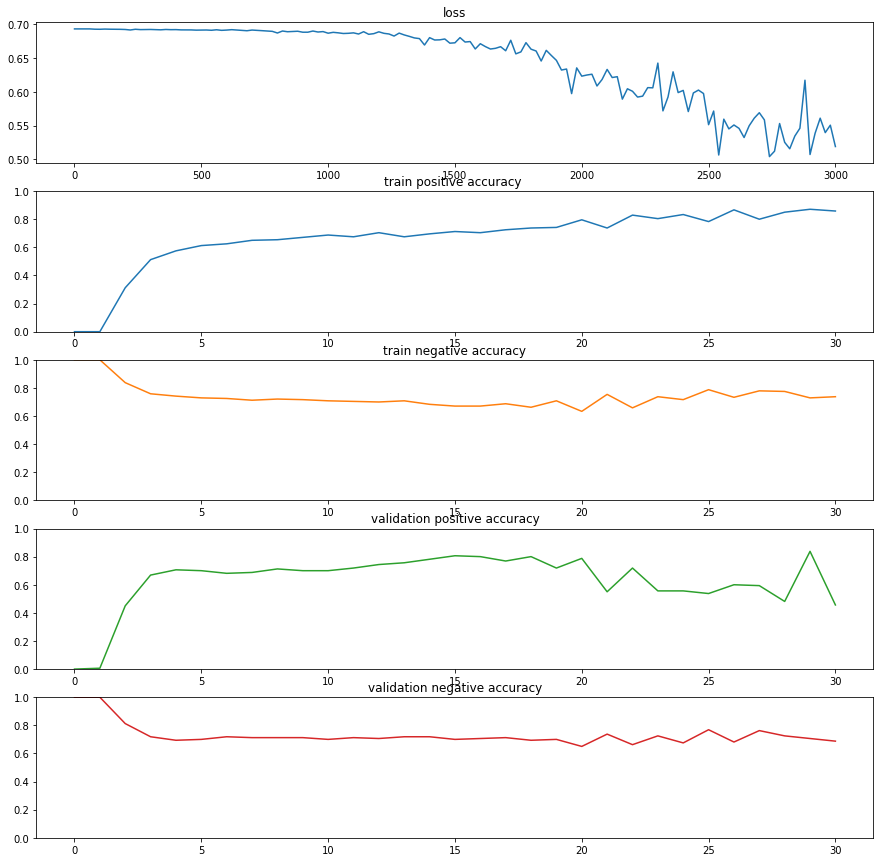

In [48]:
plot_analisys(CNN2_cardio_cut224X242,[CNN2_cardio_cut224X242_losses, CNN2_cardio_cut224X242_train_accs_pos, CNN2_cardio_cut224X242_train_accs_neg, CNN2_cardio_cut224X242_val_accs_pos, CNN2_cardio_cut224X242_val_accs_neg])

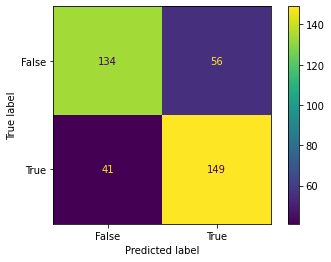

In [104]:
CNN2_cardio_cut224X242.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_CNN2-Cardio_cut_224X2422900'))


actual = np.concatenate((np.ones((190)),np.zeros((190))))
CNN2_cardio_cut224X242.eval()
predicted = CNN2_cardio_cut224X242(torch.concatenate((pos_test_arr[:190],neg_test_arr[:190])).reshape((380,1,224,242)).cuda())
predicted = predicted.max(1, keepdim=True)[1]
predicted = predicted.cpu().detach().numpy()
confusion_matrix(actual,predicted)


# training summerize and conclusions

In the last chapter we built two architectures and tried different transformation of data like cropping and resizing and different hyperparameter.

We will write down our summerize and conclusions:

1. The first model reached an overfitting with lower accuracy results (average of 71.5% percent), in the second model we added max pooling layers which that fixed the phenomenon.
2. Adding additional arguments cause a slower data memorization but also cause bias that made it hard for the model to learn the data.
3. cropping the images helped the model to give more attention to the heart area which is the source of cardiomegaly pathology what helped the model to learn the data. 

# Using famous deep learning architectures:

we will try to use two deep learining models, Alexnet and Resnet18.

# AlexNet


this network comprises of 5 convolutional layers, which begin with an 11x11 kernel. It was the pioneer in utilizing max-pooling layers, ReLu activation functions, and dropout for the 3 large linear layers. The network was used for image classification with 1000 potential classes, which was considered a remarkable feat. 
It's important to mention that those models built for three channels images, the efficeint solution for this difference is to multiply the one channel image by 3 and create a rgb image.

We will implement Alexnet class:

In [110]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 2) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        #self.block = nn.Linear(4099, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor: #add "vars" argument for variables
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #x = torch.cat((x,vars),1)
        #x = self.block(x)
        return x

In [111]:
if torch.cuda.is_available():
  alexnet_model224X242 = AlexNet().cuda()
else:
  alexnet_model224X242 = AlexNet()

In [109]:
alexnet_model224X242,alexnet_model224X242_losses, alexnet_model224X242_train_accs_pos, alexnet_model224X242_train_accs_neg, alexnet_model224X242_val_accs_pos, alexnet_model224X242_val_accs_neg  = nn_train1(alexnet_model224X242,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.001,
              weight_decay=0,
              max_iters=2000,
              vars=False,
              checkpoint_path=path_saving+'_alexnet_model_224X242')

Iter 0. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.693093]
Iter 100. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.693085]
Iter 200. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.693326]
Iter 300. [Val pos Acc 100%] [Val neg Acc 0%] [Train pos Acc 100%,Train neg Acc 0%, Loss 0.693042]
Iter 400. [Val pos Acc 99%] [Val neg Acc 3%] [Train pos Acc 100%,Train neg Acc 2%, Loss 0.693075]
Iter 500. [Val pos Acc 99%] [Val neg Acc 26%] [Train pos Acc 97%,Train neg Acc 17%, Loss 0.693212]
Iter 600. [Val pos Acc 96%] [Val neg Acc 34%] [Train pos Acc 90%,Train neg Acc 30%, Loss 0.692981]
Iter 700. [Val pos Acc 95%] [Val neg Acc 38%] [Train pos Acc 84%,Train neg Acc 37%, Loss 0.693245]
Iter 800. [Val pos Acc 91%] [Val neg Acc 41%] [Train pos Acc 82%,Train neg Acc 40%, Loss 0.692849]
Iter 900. [Val pos Acc 90%] [Val neg Acc 44%] [Train pos Acc 80%,Train neg Acc 40%, Loss 0.693126]
Iter 1000. [V

In [112]:
alexnet_model224X242.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_alexnet_model_224X2422000'))

alexnet_model224X242,alexnet_model224X242_losses, alexnet_model224X242_train_accs_pos, alexnet_model224X242_train_accs_neg, alexnet_model224X242_val_accs_pos, alexnet_model224X242_val_accs_neg  = nn_train1(alexnet_model224X242,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.005,
              weight_decay=0,
              max_iters=3000,
              vars=False,
              checkpoint_path=path_saving+'_alexnet_model2_224X242')

Iter 0. [Val pos Acc 81%] [Val neg Acc 50%] [Train pos Acc 74%,Train neg Acc 44%, Loss 0.693156]
Iter 100. [Val pos Acc 80%] [Val neg Acc 48%] [Train pos Acc 77%,Train neg Acc 43%, Loss 0.692694]
Iter 200. [Val pos Acc 69%] [Val neg Acc 61%] [Train pos Acc 66%,Train neg Acc 53%, Loss 0.691936]
Iter 300. [Val pos Acc 59%] [Val neg Acc 63%] [Train pos Acc 63%,Train neg Acc 55%, Loss 0.692730]
Iter 400. [Val pos Acc 17%] [Val neg Acc 92%] [Train pos Acc 26%,Train neg Acc 88%, Loss 0.689781]
Iter 500. [Val pos Acc 62%] [Val neg Acc 55%] [Train pos Acc 72%,Train neg Acc 52%, Loss 0.674705]
Iter 600. [Val pos Acc 49%] [Val neg Acc 74%] [Train pos Acc 67%,Train neg Acc 72%, Loss 0.599951]
Iter 700. [Val pos Acc 79%] [Val neg Acc 56%] [Train pos Acc 84%,Train neg Acc 54%, Loss 0.567029]
Iter 800. [Val pos Acc 59%] [Val neg Acc 79%] [Train pos Acc 74%,Train neg Acc 78%, Loss 0.447309]
Iter 900. [Val pos Acc 86%] [Val neg Acc 57%] [Train pos Acc 92%,Train neg Acc 54%, Loss 0.510375]
Iter 1000. [

In [140]:
alexnet_model224X242.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_alexnet_model2_224X2422400'))

test_acc_pos , test_acc_neg = get_accuracy(alexnet_model224X242, pos_test_arr,neg_test_arr,batch_size=1,vars=False)
print(f'positive test results: {test_acc_pos}\n')
print(f'negative test results: {test_acc_neg}')

positive test results: 0.8350515463917526

negative test results: 0.7474226804123711


In [128]:
def gray2rgb(x):
  return torch.cat((x,x,x),3)



### performance and insights
in the architecture above we see a high accuracy results, and we hyperparameters in our model

## ResNet 

ResNet18 is a popular deep learning architecture for image classification tasks. It consists of 18 layers, including a convolutional neural network and residual connections.

The residual connections in ResNet18 allow the model to learn a more complex and deep representation of the input image, enabling it to achieve high accuracy on image classification tasks.

In [51]:
if torch.cuda.is_available():
  resnet18_model224X242 = torchvision.models.resnet18(num_classes=2).cuda()
else:
  resnet18_model224X242 = torchvision.models.resnet18(num_classes=2)

In [231]:
resnet18_model224X242,resnet18_model224X242_losses, resnet18_model224X242_train_accs_pos, resnet18_model224X242_train_accs_neg, resnet18_model_val_accs_pos, resnet18_model224X242_val_accs_neg  = nn_train1(resnet18_model224X242,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=10,learning_rate=0.00001,
              weight_decay=0,
              max_iters=3000,
              vars=False,
              checkpoint_path=path_saving+'resnet18_model224X242_')

Iter 0. [Val pos Acc 1%] [Val neg Acc 100%] [Train pos Acc 0%,Train neg Acc 100%, Loss 0.762859]
Iter 100. [Val pos Acc 36%] [Val neg Acc 85%] [Train pos Acc 20%,Train neg Acc 82%, Loss 0.763611]
Iter 200. [Val pos Acc 67%] [Val neg Acc 71%] [Train pos Acc 39%,Train neg Acc 69%, Loss 0.734186]
Iter 300. [Val pos Acc 69%] [Val neg Acc 65%] [Train pos Acc 51%,Train neg Acc 60%, Loss 0.678285]
Iter 400. [Val pos Acc 77%] [Val neg Acc 60%] [Train pos Acc 59%,Train neg Acc 56%, Loss 0.679918]
Iter 500. [Val pos Acc 79%] [Val neg Acc 62%] [Train pos Acc 56%,Train neg Acc 59%, Loss 0.679288]
Iter 600. [Val pos Acc 80%] [Val neg Acc 63%] [Train pos Acc 59%,Train neg Acc 58%, Loss 0.722235]
Iter 700. [Val pos Acc 79%] [Val neg Acc 64%] [Train pos Acc 57%,Train neg Acc 60%, Loss 0.709400]
Iter 800. [Val pos Acc 79%] [Val neg Acc 61%] [Train pos Acc 60%,Train neg Acc 57%, Loss 0.638767]
Iter 900. [Val pos Acc 86%] [Val neg Acc 61%] [Train pos Acc 62%,Train neg Acc 57%, Loss 0.703654]
Iter 1000. [

<Figure size 432x288 with 0 Axes>

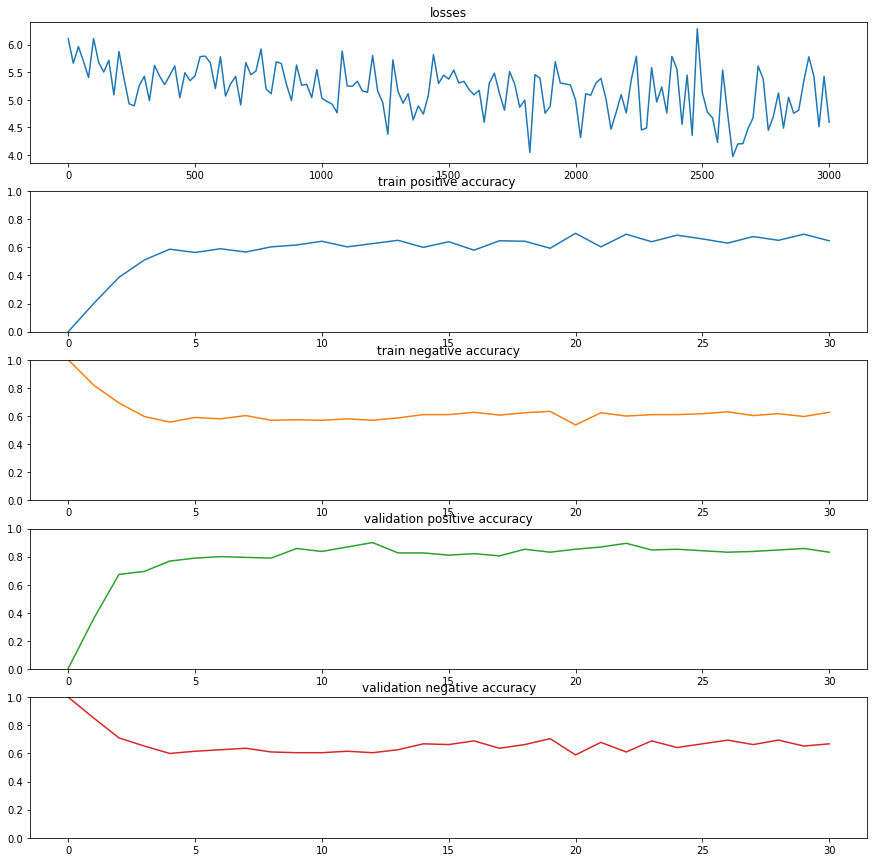

In [232]:
plot_analisys(resnet18_model224X242,[resnet18_model224X242_losses, resnet18_model224X242_train_accs_pos, resnet18_model224X242_train_accs_neg, resnet18_model_val_accs_pos, resnet18_model224X242_val_accs_neg])

In [54]:
resnet18_model224X242.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardioresnet18_model224X242_2700'))

test_acc_pos , test_acc_neg = get_accuracy(resnet18_model224X242, pos_test_arr,neg_test_arr,batch_size=1,vars=False)
print(f'positive test results: {test_acc_pos}\n')
print(f'negative test results: {test_acc_neg}')

positive test results: 0.7422680412371134

negative test results: 0.6030927835051546


**False negative images**

torch.Size([40, 224, 242, 1])


<ipython-input-215-de9886c06458>:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


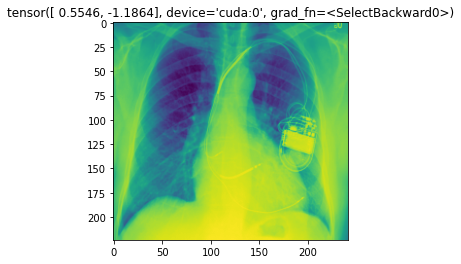

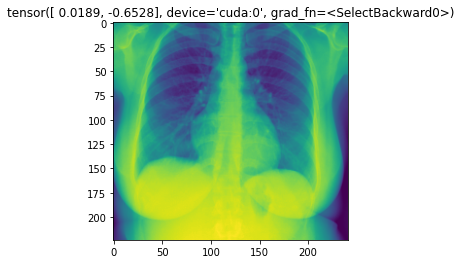

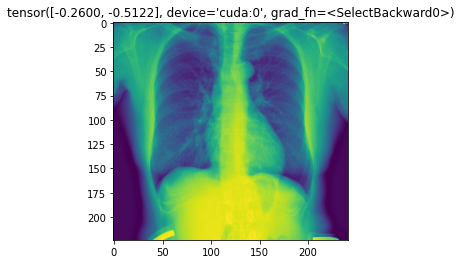

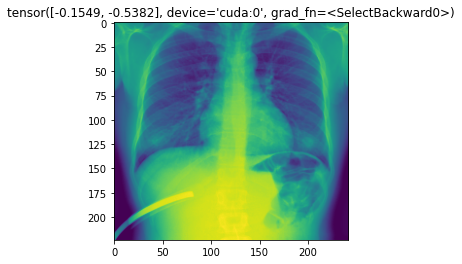

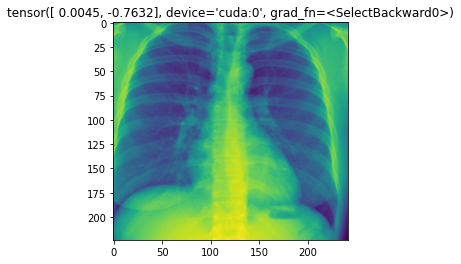

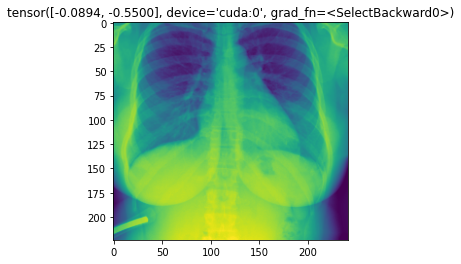

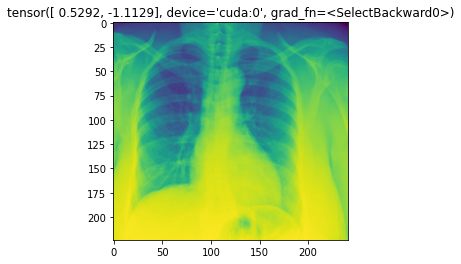

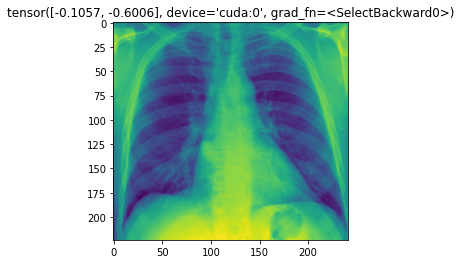

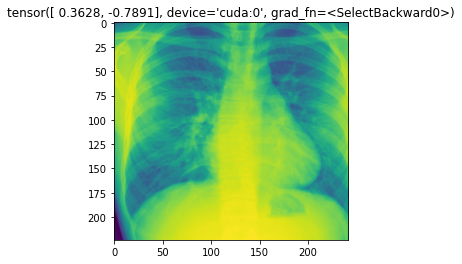

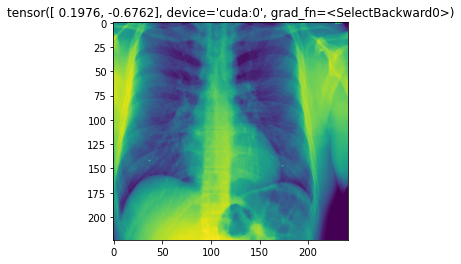

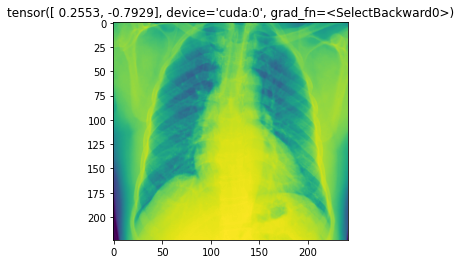

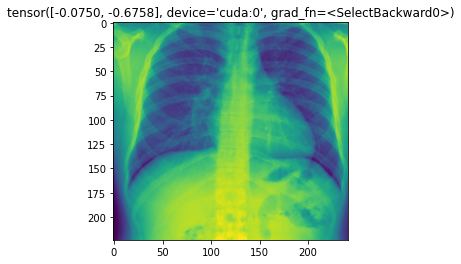

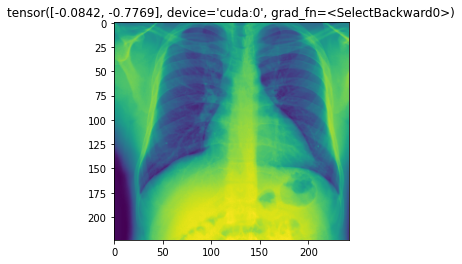

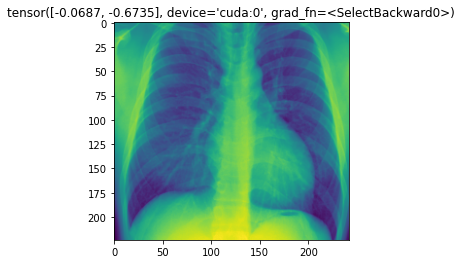

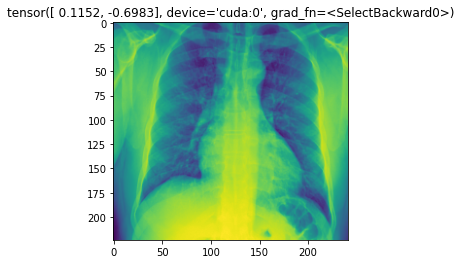

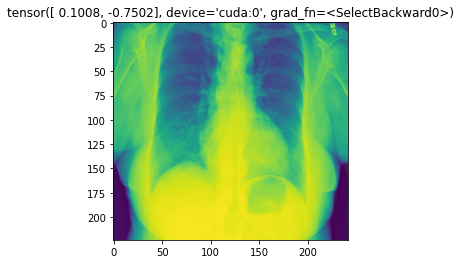

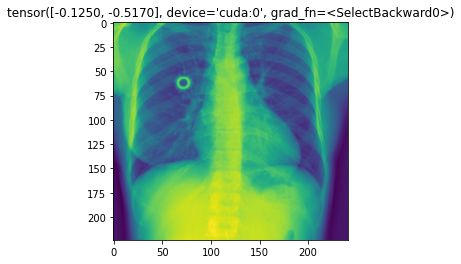

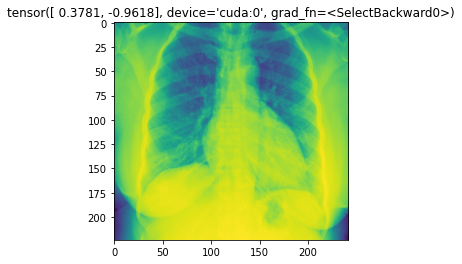

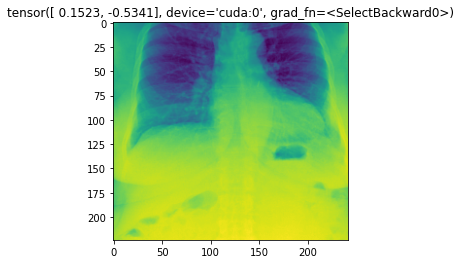

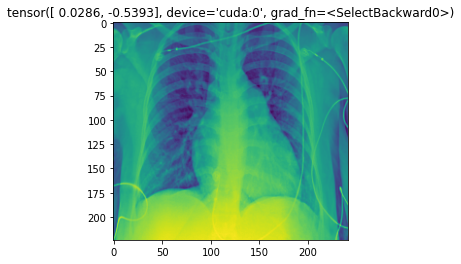

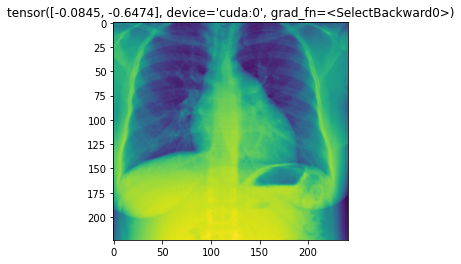

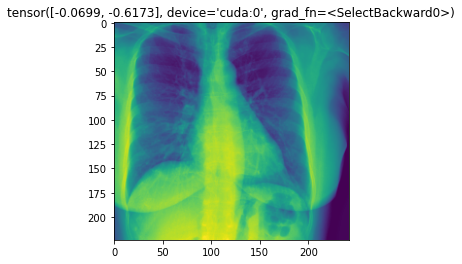

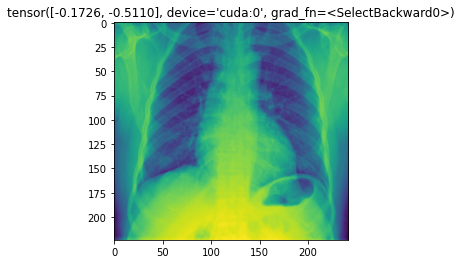

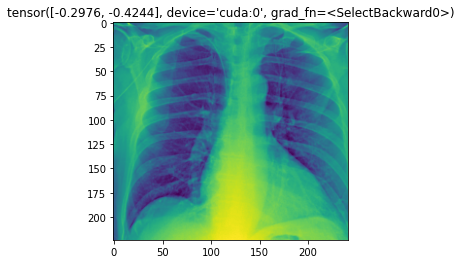

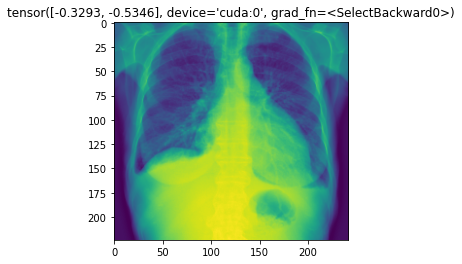

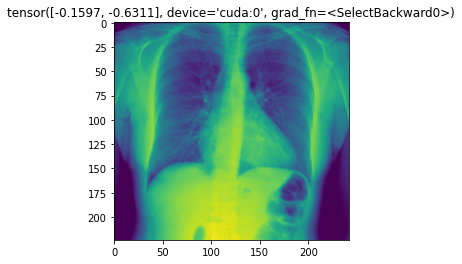

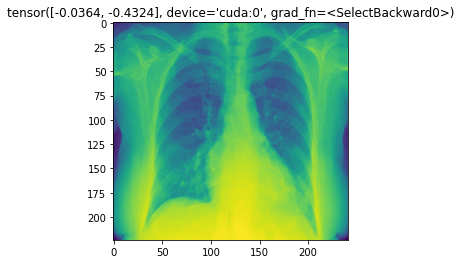

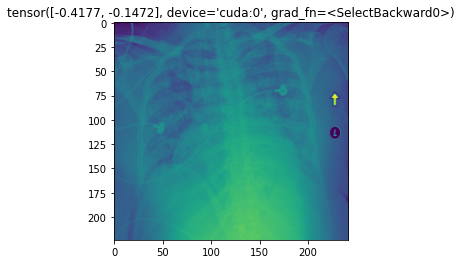

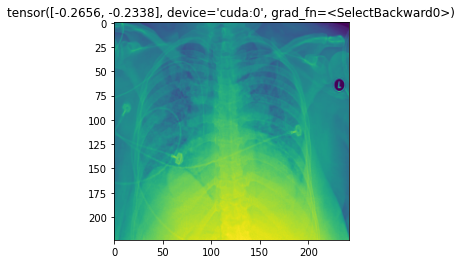

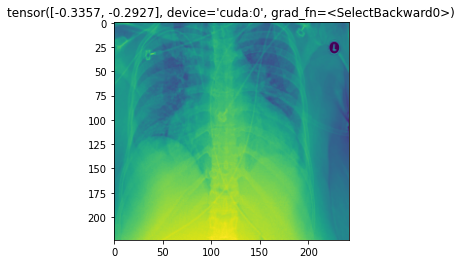

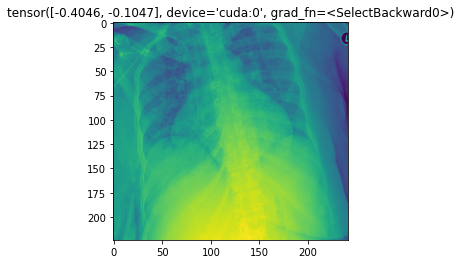

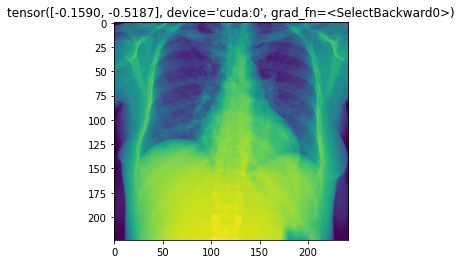

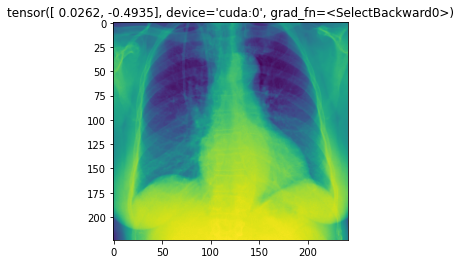

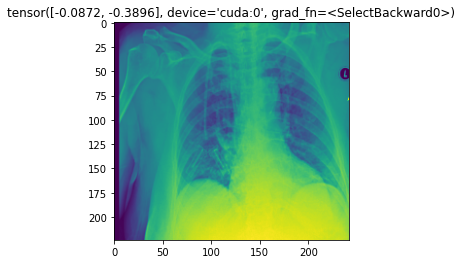

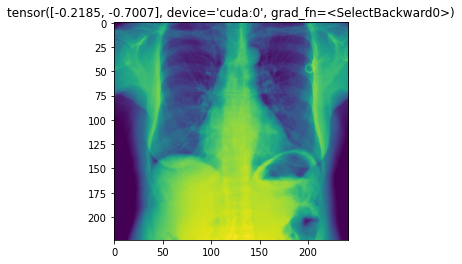

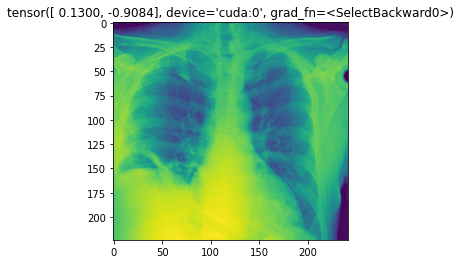

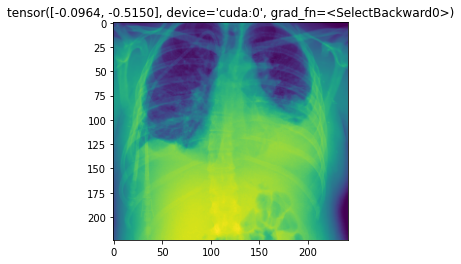

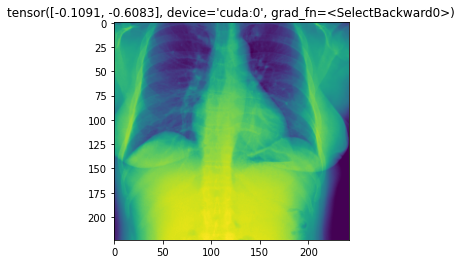

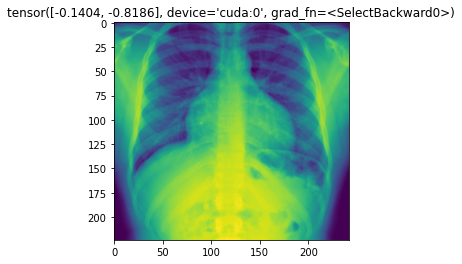

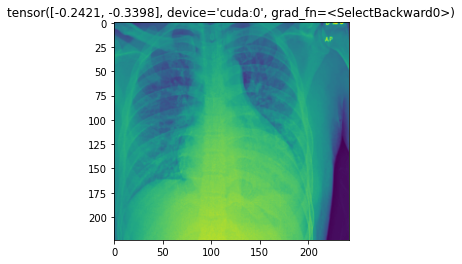

In [215]:
resnet18_model224X242.eval()

x= pos_test_arr[:40].reshape((40,224,242,1))
x= gray2rgb(x)
x=x.reshape((40,3,224,242))
finding=resnet18_model224X242(x.cuda())
for i in range(40):  
  if finding[0][0]>finding[0][1]:
    plt.figure()
    plt.imshow(np.array(pos_test_arr[i]))
    plt.title(str(finding[i]))

# Expanding Our Diagnosis 

after reaching good results with our task for the project, we examined an option of using a similar approach in order to train a model for infering over some pathologies at once.

In [ ]:
PATHOLOGY_1 = 'Mass'
PATHOLOGY_2 = 'Effusion'
PATHOLOGY_3 = 'Atelectasis'

# add pathologies
all_xray_df[PATHOLOGY_1] = [(PATHOLOGY_1 in x)*1 for x in all_xray_df['Finding Labels']]
all_xray_df[PATHOLOGY_2] = [(PATHOLOGY_2 in x)*1 for x in all_xray_df['Finding Labels']]
all_xray_df[PATHOLOGY_3] = [(PATHOLOGY_3 in x)*1 for x in all_xray_df['Finding Labels']]

print(f"number of patients diagnosed with {PATHOLOGY_1}: {np.sum(all_xray_df[PATHOLOGY_1])}")
print(f"number of patients diagnosed with {PATHOLOGY_2}: {np.sum(all_xray_df[PATHOLOGY_2])}")
print(f"number of patients diagnosed with {PATHOLOGY_3}: {np.sum(all_xray_df[PATHOLOGY_3])}")
print(f"number of patients diagnosed with No Finding: {np.sum(all_xray_df['No Finding'])}")

# make a dataset of 4 pathologies plus 3000 patients with no findings
mask1 = all_xray_df[PATHOLOGY_1] == 1
mask2 = all_xray_df[PATHOLOGY_2] == 1
mask3 = all_xray_df[PATHOLOGY_3] == 1  

mask = [mask1[i] or mask2[i] or mask3[i] for i in range(len(mask1))]
diagnosed = all_xray_df.loc[mask]
diagnosed = diagnosed.reset_index(drop=True)


neg_mask = all_xray_df['No Finding'] == 1
negative = all_xray_df.loc[neg_mask]
negative = negative.sample(n=3000).reset_index(drop=True)





number of patients diagnosed with Mass: 5782
number of patients diagnosed with Effusion: 13317
number of patients diagnosed with Atelectasis: 11559
number of patients diagnosed with No Finding: 60361


As seen, the dataset is large enough, and it is optional to build a relatively balanced dataset with around 5000 images for eachpathology.

In [ ]:
print(f"number of patients diagnosed with {PATHOLOGY_1}: {np.sum(diagnosed[PATHOLOGY_1])}")
print(f"number of patients diagnosed with {PATHOLOGY_2}: {np.sum(diagnosed[PATHOLOGY_2])}")
print(f"number of patients diagnosed with {PATHOLOGY_3}: {np.sum(diagnosed[PATHOLOGY_3])}")
print(f"number of patients diagnosed with No Finding: {np.sum(diagnosed['No Finding'])}")

number of patients diagnosed with Mass: 5782
number of patients diagnosed with Effusion: 13317
number of patients diagnosed with Atelectasis: 11559
number of patients diagnosed with No Finding: 0


In [ ]:
diagnosed = pd.concat([diagnosed[diagnosed['Effusion'] == 0],diagnosed[diagnosed['Effusion'] == 1].sample(6000)])

print(f"number of patients diagnosed with {PATHOLOGY_1}: {np.sum(diagnosed[PATHOLOGY_1])}")
print(f"number of patients diagnosed with {PATHOLOGY_2}: {np.sum(diagnosed[PATHOLOGY_2])}")
print(f"number of patients diagnosed with {PATHOLOGY_3}: {np.sum(diagnosed[PATHOLOGY_3])}")
print(f"number of patients diagnosed with No Finding: {np.sum(diagnosed['No Finding'])}")

number of patients diagnosed with Mass: 5089
number of patients diagnosed with Effusion: 6000
number of patients diagnosed with Atelectasis: 9749
number of patients diagnosed with No Finding: 0


In [ ]:
diagnosed = pd.concat([diagnosed[diagnosed['Atelectasis'] == 0],diagnosed[diagnosed['Atelectasis'] == 1].sample(5600)])

print(f"number of patients diagnosed with {PATHOLOGY_1}: {np.sum(diagnosed[PATHOLOGY_1])}")
print(f"number of patients diagnosed with {PATHOLOGY_2}: {np.sum(diagnosed[PATHOLOGY_2])}")
print(f"number of patients diagnosed with {PATHOLOGY_3}: {np.sum(diagnosed[PATHOLOGY_3])}")
print(f"number of patients diagnosed with No Finding: {np.sum(diagnosed['No Finding'])}")

number of patients diagnosed with Mass: 4851
number of patients diagnosed with Effusion: 5384
number of patients diagnosed with Atelectasis: 5600
number of patients diagnosed with No Finding: 0


### Dataset Preparation

As we did before with the single pathology network, we split the dataset to train, validation and test, and saving it as tensors for optimiztion in training.

In [ ]:
TRAINSIZE = 0.86
VALSIZE = 0.93


p =len(diagnosed)
n = len(negative)
N = n+p

# split the dataset to train test validation sets
data = pd.concat([diagnosed,negative]).sample(frac=1).reset_index(drop=True)

data_train, data_test, data_val = data.iloc[:int(TRAINSIZE*N)], data.iloc[int(TRAINSIZE*N):int(VALSIZE*N)],data.iloc[int(VALSIZE*N):]

data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)



In [ ]:
def collect_tensor(data,H,W):
  n=len(data)
  data_array = torch.zeros((n,H,W))
  variables = torch.zeros((n,3))
  ts = torch.zeros((n,3))

  for j in tqdm(range(n)):

    if plt.imread(data['path'][j]).shape==(1024,1024):
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[50:-50,50:-50],(H,W)))   
    else:
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[50:-50,50:-50,0],(H,W)))

    ts[j] = torch.tensor([data[PATHOLOGY_1][j],data[PATHOLOGY_2][j],data[PATHOLOGY_3][j]])
    #variables[j,0] = data['Patient Age'][j]
    #variables[j,1] = data['Gender'][j]
    #variables[j,2] = data['position'][j]
  return data_array, ts
     

In [ ]:
from tqdm import tqdm

In [ ]:
H,W = 224,224

x_train, t_train = collect_tensor(data_train,H,W)

x_test , t_test = collect_tensor(data_test,H,W)

x_val  , t_val = collect_tensor(data_val,H,W)


100%|██████████| 1206/1206 [01:22<00:00, 14.55it/s]


### Network Architecture

The architecture is similar to the ones implemented above, except, the problem we tried to solve is a binary classification problem (has or has not Cardiomegaly) hence, we used a binary classifyer.

As we know it is possible for the patients to be diagnosed with more than one pathology. so we will implement a multilable classifier.

In [ ]:

class CNN2(nn.Module):
    def __init__(self, num_hiddens,num_vars = 0):

        
        super(CNN2, self).__init__()

        self.H = 224
        self.W = 224
        in_channels = 1
        self.num_hiddens = num_hiddens
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, num_hiddens*2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*2),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.block3 = nn.Sequential(nn.Conv2d(num_hiddens*2, num_hiddens*4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*4))
        
        self.block4 = nn.Sequential(nn.Conv2d(num_hiddens*4, num_hiddens*8, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*8))


        self.fc_block1 = nn.Sequential(nn.Linear(4*4*8*num_hiddens,70), #flatten the CNN output
                                       nn.Sigmoid())
        

        
        self.fc_block2 =  nn.Sequential(nn.Linear(100 , 3), #flatten the CNN output
                                       nn.Sigmoid())
        

    def forward(self,x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.contiguous().view(-1,4*4*8*self.num_hiddens) # reshape for tensor

        x = self.fc_block1(x)
        #x= torch.cat((x,vars),1)
        x = self.fc_block2(x)

        return x

In [ ]:
from math import floor

### Accuracy Function
we will want to track the accuracy of EACH possible pathology diagnosis, positive and negative alike.

In [ ]:
def get_acc(model, x, t, v = None, n = 200, with_vars=False,Alex= False):
    # calculate accurecy history
    # for each pathology we should have [positive accuracy,negative accuracy]
    # positive accuracy = True Positives/Positive predictions
    # negative accuracy = True Negatives/Negative predictions

    ## acc_history = [pathology1 acc, apthology2 acc ... ]


    # draw a random batch from our train/val dataset tensor
    perm = torch.randperm(x.size(0))
    idx = perm[:n]
    # reshape xt
    xt = x[idx].reshape((n,1,H,W))  
    st = t[idx]  # expected value
    if Alex:
      xt=torch.cat((xt,xt,xt),1)


    #optimizing performance using cuda
    if torch.cuda.is_available():
        xt , st = xt.cuda(), st.cuda()

    # forwarding the model
    if with_vars:
        zs = model(xt, vars)
    else:
        zs = model(xt)

    #print(f'zs = {zs}')
    # true positives are the sum over the true values
    p_acc = [0,0,0]
    n_acc = [0,0,0]
    
    # run over all predictions

    for j in range(3): #for each pathology
        NegativePredictions = 0
        PositivePredictions = 0

        TruePositives = 0
        TrueNegatives = 0
        for i in range(len(zs)):    #for each image
            # if the diagnosis is correct
            if t[i,j] == 1:

                #if positive: add to count of P
                PositivePredictions += 1

                if zs[i, j] > 0.5:
                    # if positive and predicted well: add to count of TP
                    TruePositives += 1   
                    #print(f'Truepos = {TruePositives}')
            if t[i,j] == 0: #same for Negatives : 0
                    NegativePredictions += 1

                    if zs[i, j] < 0.5:
                      TrueNegatives += 1

        # getting acc for each pathology
        p_acc[j] = TruePositives / PositivePredictions
        n_acc[j] = TrueNegatives / NegativePredictions
        #print(f'Truepos = {TruePositives}, PosPreds = {PositivePredictions},\t PACC ={p_acc}')

    acc = [p_acc, n_acc]

    acc = [list(i) for i in zip(*acc)]

    return acc


### Train function



In [ ]:
def nn_train4(model,
              x_train = x_train,
              t_train = t_train,

              x_val = x_val,
              t_val = t_val,

              batch_size=10,
              learning_rate=0.001,
              weight_decay=0,
              max_iters=40000,
              checkpoint_path=None,
              with_vars = False,
              Alex=False
              ):
  

  #main training loop; choice of loss function; choice of optimizer
  criterion = nn.BCEWithLogitsLoss()
  criterion = criterion.cuda()
  
  
  optimizer = optim.SGD(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay,
                           momentum=0.9)
  
  iters, losses = [], []
  train_acc_history = []  
  val_acc_history = []  

  len_data= len(x_train)
  H=224
  W=224
  n = 0 # the number of iterations
  while n < max_iters:
      for i in range(0, len_data, batch_size):
            if (i + batch_size) > len_data:
                break
            
            #set the model to 'training mode'
            model.train()
            #define empty tensor for batch
            xt=torch.zeros((batch_size,H,W))      

            #draw a random batch from our train dataset tensor
            perm = torch.randperm(x_train.size(0))
            idx = perm[:batch_size]            

            xt = x_train[idx].reshape((batch_size,1,H,W))
            st = t_train[idx]
            #print(f'st={st}')
            
            #conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions  N×C×H×W  (known as NCHW tensor)
            #.. where  N  is the number of images batch size,  C  is the number of channels,  H  is the height of the image, and  W  is the width of the image.
            
            if Alex:
              xt=torch.cat((xt,xt,xt),1)


            #optimizing performance using cuda
            if torch.cuda.is_available():
                xt , st = xt.cuda(), st.cuda()

            # forwarding the model
            if with_vars:
              zs = model(xt,vars) 
            else:
              zs = model(xt)
            optimizer.zero_grad()
            loss = criterion(zs, st)
            loss.backward()
            losses.append(float(loss)/batch_size) 
            optimizer.step()
            
            
            #after every epoch, report the accuracies for the training set and validation set
            if n % 1000==0:
                
                # save the loss
                train_cost = float(loss.detach().cpu().numpy())

                # calculate accurecy history 
                # for each pathology we shuld have [positive accuracy,negative accuracy]
                # positive accuracy = True Positive/Positive predictions
                # negative accuracy = True negative/negative predictions

                # acc_history = [pathology1 acc, apthology2 acc ... ] 
                train_h = get_acc(    model,
                                      x_train,
                                      t_train,
                                      n=batch_size,
                                      Alex=Alex
                                  
                                      )
                val_h = get_acc(      model,
                                      x_val,
                                      t_val,
                                      n=batch_size,
                                      Alex=Alex
                                      )        
                #TODO: edit this
                train_acc_history.append(train_h)
                val_acc_history.append(val_h)
                
                train_h = [[i * 100 for i in x] for x in train_h]
                val_h = [[i * 100 for i in x] for x in val_h]
                map(int,train_h)
                map(int,val_h)
                

                print(f'\
                \nIter {n}. \n{PATHOLOGY_1}:\t\t[Val pos Acc {val_h[0][0]}%] [Val neg Acc {val_h[0][1]}] \t\t Train: [ pos Acc {train_h[0][0]}%, neg Acc {train_h[0][1]}%]\
                          \n{PATHOLOGY_2}:\t[Val pos Acc {val_h[1][0]}%] [Val neg Acc {val_h[1][1]}] \t\t Train: [ pos Acc {train_h[1][0]}%, neg Acc {train_h[1][1]}%]\
                          \n{PATHOLOGY_3}:\t[Val pos Acc {val_h[2][0]}%] [Val neg Acc {val_h[2][1]}] \t\t Train: [ pos Acc {train_h[2][0]}%, neg Acc {train_h[2][1]}%]\
                          \nloss: {train_cost}' 
                )


                
                if (n>500 and n % 1000==0 and checkpoint_path is not None):  #save model
                    n_path = checkpoint_path + f"{n}"
                    torch.save(model.state_dict(), n_path.format(n))
            # increment the iteration number
            n += 1

            if n > max_iters:
              return model,losses, train_acc_history,val_acc_history
        
            
            


          #track the training curve information and plot the training curve
        
              
  return  model,losses, train_acc_history,val_acc_history

### Bench Marks
as done before, we will examine the performance of Alexnet's model for the sake of comparison 

In [ ]:
if torch.cuda.is_available():
  CNN_3_path = CNN2(100).cuda()
else:
  CNN_3_path = CNN2(100)

In [130]:
if torch.cuda.is_available():
  Alex_model = AlexNet(num_classes=3).cuda()
else:
  Alex_model = AlexNet(num_classes=3).cuda()

In [ ]:
 Alex_model,losses, train_acc_history,val_acc_history =  nn_train4( Alex_model,
                                                                    x_train,
                                                                    t_train,
                                                                    x_val,
                                                                    t_val,
                                                                    batch_size=180,
                                                                    learning_rate=0.01,
                                                                    weight_decay=0,
                                                                    max_iters=10000,
                                                                    checkpoint_path=None,
                                                                    with_vars = False,
                                                                    Alex=True
                                                                    )

                
Iter 0. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Atelectasis:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
loss: 0.6914198994636536
                
Iter 1000. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Atelectasis:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
loss: 0.6053242683410645
                
Iter 2000. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 99.21259

In [ ]:
 Alex_model2 = Alex_model
 Alex_model2,losses2, train_acc_history2,val_acc_history2 =  nn_train4( Alex_model,
                                                                    x_train,
                                                                    t_train,
                                                                    x_val,
                                                                    t_val,
                                                                    batch_size=300,
                                                                    learning_rate=0.001,
                                                                    weight_decay=0,
                                                                    max_iters=5000,
                                                                    checkpoint_path=None,
                                                                    with_vars = False,
                                                                    Alex = True
                                                                    )

                
Iter 0. 
Mass:		[Val pos Acc 16.091954022988507%] [Val neg Acc 77.93427230046949] 		 Train: [ pos Acc 22.78481012658228%, neg Acc 78.73303167420815%]                          
Effusion:	[Val pos Acc 22.61904761904762%] [Val neg Acc 78.70370370370371] 		 Train: [ pos Acc 25.0%, neg Acc 75.5%]                          
Atelectasis:	[Val pos Acc 27.835051546391753%] [Val neg Acc 82.26600985221675] 		 Train: [ pos Acc 13.829787234042554%, neg Acc 71.84466019417476%]                          
loss: 0.24547544121742249
                
Iter 1000. 
Mass:		[Val pos Acc 17.24137931034483%] [Val neg Acc 82.62910798122066] 		 Train: [ pos Acc 21.518987341772153%, neg Acc 76.92307692307693%]                          
Effusion:	[Val pos Acc 23.809523809523807%] [Val neg Acc 71.75925925925925] 		 Train: [ pos Acc 27.0%, neg Acc 77.0%]                          
Atelectasis:	[Val pos Acc 24.742268041237114%] [Val neg Acc 78.81773399014779] 		 Train: [ pos Acc 32.97872340425532%, neg A

In [ ]:
 Alex_model3 = Alex_model
 Alex_model3,losses3, train_acc_history3,val_acc_history3 =  nn_train4( Alex_model,
                                                                    x_train,
                                                                    t_train,
                                                                    x_val,
                                                                    t_val,
                                                                    batch_size=500,
                                                                    learning_rate=0.003,
                                                                    weight_decay=0,
                                                                    max_iters=5000,
                                                                    checkpoint_path=None,
                                                                    with_vars = False,
                                                                    Alex = True)

                
Iter 0. 
Mass:		[Val pos Acc 15.862068965517242%] [Val neg Acc 81.69014084507043] 		 Train: [ pos Acc 25.899280575539567%, neg Acc 76.17728531855957%]                          
Effusion:	[Val pos Acc 27.77777777777778%] [Val neg Acc 75.84269662921348] 		 Train: [ pos Acc 27.160493827160494%, neg Acc 67.75147928994083%]                          
Atelectasis:	[Val pos Acc 19.1358024691358%] [Val neg Acc 75.7396449704142] 		 Train: [ pos Acc 29.411764705882355%, neg Acc 73.19884726224784%]                          
loss: 0.10490328073501587
                
Iter 1000. 
Mass:		[Val pos Acc 21.379310344827587%] [Val neg Acc 75.49295774647888] 		 Train: [ pos Acc 28.05755395683453%, neg Acc 74.51523545706371%]                          
Effusion:	[Val pos Acc 28.47222222222222%] [Val neg Acc 76.12359550561798] 		 Train: [ pos Acc 32.098765432098766%, neg Acc 69.8224852071006%]                          
Atelectasis:	[Val pos Acc 22.839506172839506%] [Val neg Acc 71.59763313609

### Analyzing Alexnet's results
at this point we understood that Alexnet isn't providng such impressing results as we thought. this might be because the network dosn't fit as well for multilabel classification problems, or our train function trains it in a sub optimal manner.
a potential solution for this occurance might be using some different datasets separately orchanging ether our training function or architecture. we assume our model will provide limited results as well, given Alexnet's performence.



In [ ]:
if torch.cuda.is_available():
  CNN_3_path = CNN2(200).cuda()
else:
  CNN_3_path = CNN2(200)

In [ ]:
 CNN_3_path,losses, train_acc_history,val_acc_history =  nn_train4(CNN_3_path,
                                                                    x_train,
                                                                    t_train,

                                                                    x_val,
                                                                    t_val,

                                                                    batch_size=200,
                                                                    learning_rate=0.05,
                                                                    weight_decay=0,
                                                                    max_iters=3000,
                                                                    checkpoint_path=None,
                                                                    with_vars = False
                                                                    )

                
Iter 0. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Atelectasis:	[Val pos Acc 5.555555555555555%] [Val neg Acc 95.3125] 		 Train: [ pos Acc 7.8125%, neg Acc 94.11764705882352%]                          
loss: 0.810431718826294
                
Iter 1000. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Atelectasis:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
loss: 0.6931487321853638


KeyboardInterrupt: ignored

we stopped the process after 2 epochs, seeing that both the loss and accuracies are not going anywhere. we assume it is due to the fact that for each disease there are more patients that are negative in diagnosis then positives.
this make the data we have been working on practically unbalanced, which caused our model to be biased 